In [413]:
import pandas as pd
import pickle
import json
import seaborn as sns
import pprint
import numpy as np
import math
import ast
pp = pprint.PrettyPrinter(depth=6)
import matplotlib
import matplotlib.pyplot as plt
from scipy import stats
import scipy
from scipy.stats import normaltest, shapiro
matplotlib.rcParams['figure.figsize'] = (14.0, 5.0)
pd.set_option('display.max_columns', 120)
pd.set_option('display.max_rows', 450)
pd.set_option("display.max_colwidth", 200)

In [414]:
pkl_folder = "../../pkl"
csv_folder = "../../csv"
figure_folder = "../../figures"

For reference: https://nbviewer.jupyter.org/github/IncioMan/socialdata/blob/master/FinalProject/TrafficDataProject.ipynb

### Import

**Tags**

In [415]:
tags = pd.read_csv(f"{csv_folder}/tags_updated.csv", index_col=0)
tags.head()

,actual_release_date,Tag,Sha,Date,month,year,major_version,jira_version
0,NaN,4.5.6,12d931e5a31e1692a428bbb34ba11cd63aebf998,2015-10-16 09:31:18,10,2015,4,4.5.6
1,NaN,4.5.7,e2afb0bff1b8be759789d2c1bc9348de6f519f83,2016-04-08 13:44:39,4,2016,4,4.5.7
2,2015-04-23 00:00:00,5.1,4aa9af3a6a4362b61db365fba32eb0a55d411e7a,2015-04-02 08:09:45,4,2015,5,5.1
3,NaN,5.1.1,0a231d24c0f1e7ce1d200274b8e9bbe00f9f49fb,2015-06-02 08:34:06,6,2015,5,5.1.1
4,NaN,5.1.2,2a52a7106b2bfbd659c591c2d6fc09ad0ab2db5c,2015-07-27 08:03:21,7,2015,5,5.1.2


In [416]:
methods= ["dataset1", "dataset2"]

In [417]:
direct_and_pr = pd.read_csv(f"{csv_folder}/final_datasets/{methods[0]}_with_sw_metrics.csv", index_col=0)

In [418]:
iterative_pr_head_ref_cherry_picked = pd.read_csv(f"{csv_folder}/final_datasets/{methods[1]}_with_sw_metrics.csv", index_col=0)

In [419]:
methods_df = {"dataset1":direct_and_pr,
             "dataset2": iterative_pr_head_ref_cherry_picked}

### Features

| Variable name                            | Variable description                                                                                               | Variable type | How many      |
|------------------------------------------|--------------------------------------------------------------------------------------------------------------------|---------------|---------------|
| ratio_{state}_build                      | Ratio number of builds in the state over all builds for the release                                                | Continuous    | 4             |
| ratio_pr_build                           | Ratio number of pull request builds in the state over all builds for the release                                   | Continuous    | 1             |
| ratio_pr_build_failed                           | Ratio number of failed pull request builds over all builds for the release                                   | Continuous    | 1
| {aggr}_{state}_build_duration            | Aggregation for the duration of the builds in that state for the release                                           | Continuous    | 4 \* 3 = 12   |
| {aggr}\_n\_builds_per_pull_request       | Aggregation of the number of builds per pull request for the release                                               | Continuous    | 4             |
| {aggr}_failed_tests                      | Aggregation of the number failed tests per build for the release                                                   | Continuous    | 4
| {aggr}_passed_tests                      | Aggregation of the number passed tests per build for the release                                                   | Continuous    | 4
| {aggr}_total_tests                      | Aggregation of the number total tests per build for the release                                                   | Continuous    | 4
| {aggr}_skipped_tests                      | Aggregation of the number skipped tests per build for the release                                                   | Continuous    | 4|
| {aggr}_errors_over_tests_total           | Aggregation of the number of error words over the tests run per build for the release                              | Continuous    | 4             |
| {aggr}_failures_over_tests_total         | Aggregation of the number of failures words over the tests run per build for the release                           | Continuous    | 4             |
| {aggr}_skipped_over_tests_total          | Aggregation of the number of skipped words over the tests run per build for the release                            | Continuous    | 4             |
| {aggr}\_n\_exceptions                    | Aggregation of the number of thrown exceptions per build for the release                                           | Continuous    | 4             |
| {aggr}\_n\_warnings                      | Aggregation of the number of warning words per build for the release                                               | Continuous    | 4             |
| {aggr}\_n\_error_classes                 | Aggregation of the number of error classes thrown per build for the release                                        | Continuous    | 4             |
| {state}\_gp{x}\_bs{y}\_n\_bursts_{aggr}  | Aggregation over number of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y    | Continuous    | 3 \*9 \*4=108 |
| {state}\_gp{x}\_bs{y}\_burst_size_{aggr} | Aggregation over the sizes of bursts per commitref (branch/pull req) for a release, with gapsize x and burstsize y | Continuous    | 3 \*9 \*4=108 |
|                                          |                                                                                                                    |               | Total = 278   |

Remove unwanted features

In [420]:
for method in methods:
    methods_df[method] = methods_df[method].drop(columns=["ratio_pr_builds_failed"])

**Size**

In [421]:
for method in methods:
    print(methods_df[method].shape)

(52, 300)
(52, 300)


**Number burst metrics**

In [422]:
for method in methods:
    print(len([x for x in methods_df[method].columns if "burst" in x]))

216
216


**Number non burst metrics**

In [423]:
for method in methods:
    print(len([x for x in methods_df[method].columns if not "burst" in x]))

84
84


**Masks fo java build tool**

In [424]:
for method, df in methods_df.items():
    gradle_mask = df.java_build_tool == "gradle"
    print("Gradle", gradle_mask.sum())
    maven_mask = df.java_build_tool == "maven"
    print("Maven", maven_mask.sum())

Gradle 20
Maven 32
Gradle 20
Maven 32


In [425]:
all_mask = [True]*len(methods_df[methods[0]])

In [426]:
mask_name = "all"
mask_to_use = all_mask

**Extracting the dependent variables** 

In [427]:
dep_var_cols = ["java_build_tool","post_release_bugs", "fix_time", "dde", "critical_post_release_bugs", "minor_post_release_bugs"]

In [428]:
methods_dep_var = {}
for method in methods:
    methods_dep_var[method] = methods_df[method]\
    [dep_var_cols]
    methods_dep_var[method] = methods_dep_var[method][mask_to_use]

**Extracting the independent variables**

In [429]:
extra_info_cols = ['version_name','from_author_date', 'to_author_date', 'ahead_by', 'behind_by',
       'from_sha', 'to_sha', 'ahead_behind_sum', 'diff_author_dates',
       'diff_author_days', 'from_commit_date','to_commit_date', 'diff_commit_dates', 'diff_commit_days', 'to_tag',
       'from_tag', "java_build_tool"]

In [430]:
pre_release_bugs_columns = ["pre_release_bugs"]

In [431]:
methods_indep_var = {}
for method in methods:
    methods_indep_var[method] = methods_df[method].drop(columns=extra_info_cols + pre_release_bugs_columns + dep_var_cols)
    methods_indep_var[method] = methods_indep_var[method][mask_to_use]
    print(method, methods_indep_var[method].shape)

dataset1 (52, 277)
dataset2 (52, 277)


### Missing values

In [432]:
methods_indep_var[methods[0]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [433]:
methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0]

Index(['mean_failed_build_duration', 'median_failed_build_duration',
       'max_failed_build_duration', 'min_failed_build_duration',
       'mean_passed_build_duration', 'median_passed_build_duration',
       'max_passed_build_duration', 'min_passed_build_duration'],
      dtype='object')

In [434]:
df = methods_indep_var[methods[0]]
df[df.min_failed_build_duration.isna()]

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,min_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,min_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,min_n_error_classes,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs1_burst_size_min,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,...,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs1_burst_size_min,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs2_burst_size_min,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp2_bs3_burst_size_min,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs1_burst_size_min,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs2_burst_size_min,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max,failed_gp3_bs3_burst_size_min,mean_skipped_tests,median_skipped_tests,max_skipped_tests,min_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests
34,1.000000,0.0,0.0,0.000000,0.0,1343.090909,1339.0,1529.0,1146.0,NaN,NaN,NaN,NaN,1343.090909,1339.0,1529.0,1146.0,0.0,0.0,0,0,1.501101,1.501109,3.0,0.002188,0.0,0.0,0.0,0.0,2.001101,2.001109,4.0,0.002188,0.000367,0.000365,0.00074,0.000000,0.000000,0.0,0,0,19.000000,19.0,22.0,16.0,0.0,0.0,0,0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,...,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.000000,2.0,4.0,0.0,681.000000,675.5,1370.0,0.0,679.000000,673.5,1366.0,0.0
40,0.000000,0.0,0.0,1.000000,0.0,NaN,NaN,NaN,NaN,

If we look at the ratio of builds in the state, we see that both datasets have missing values for duration due to no builds in that state being associated with that release.
We replace the values with 0.

In [435]:
for method in methods:
    methods_indep_var[method].fillna(0, inplace=True)

In [436]:
len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[1]].isna().sum()>0])\
+ len(methods_indep_var[methods[1]].columns[\
                                    methods_indep_var[methods[0]].isna().sum()>0])

0

### Drop columns with no information

In [437]:
method_uninformative_columns = {}
for method in methods:
    df = methods_indep_var[method]
    nunique = df.apply(pd.Series.nunique)
    cols_to_drop = nunique[nunique == 1].index
    method_uninformative_columns[method] = cols_to_drop
    methods_indep_var[method] = df.drop(cols_to_drop, axis=1)
    print(method, methods_indep_var[method].shape)

dataset1 (52, 246)
dataset2 (52, 246)


In [438]:
print(method_uninformative_columns[methods[0]].nunique())
print(method_uninformative_columns[methods[1]].nunique())

31
31


In [439]:
set(method_uninformative_columns[methods[0]]).difference(set(method_uninformative_columns[methods[1]]))

set()

In [440]:
set(method_uninformative_columns[methods[1]]).difference(set(method_uninformative_columns[methods[0]]))

set()

In [441]:
method_uninformative_columns[methods[1]]

Index(['min_failed_tests', 'min_n_exceptions', 'min_n_error_classes',
       'not_passed_gp1_bs1_burst_size_min',
       'not_passed_gp1_bs2_burst_size_min',
       'not_passed_gp1_bs3_burst_size_min',
       'not_passed_gp2_bs1_burst_size_min',
       'not_passed_gp2_bs2_burst_size_min',
       'not_passed_gp2_bs3_burst_size_min',
       'not_passed_gp3_bs1_burst_size_min',
       'not_passed_gp3_bs2_burst_size_min',
       'not_passed_gp3_bs3_burst_size_min', 'canceled_gp1_bs1_burst_size_min',
       'canceled_gp1_bs2_burst_size_min', 'canceled_gp1_bs3_burst_size_min',
       'canceled_gp2_bs1_burst_size_min', 'canceled_gp2_bs2_burst_size_min',
       'canceled_gp2_bs3_burst_size_min', 'canceled_gp3_bs1_burst_size_min',
       'canceled_gp3_bs2_burst_size_min', 'canceled_gp3_bs3_burst_size_min',
       'failed_gp1_bs1_burst_size_min', 'failed_gp1_bs2_burst_size_min',
       'failed_gp1_bs3_burst_size_min', 'failed_gp2_bs1_burst_size_min',
       'failed_gp2_bs2_burst_size_min', 'fail

All features with aggregator minimum

### Statistical summary

**Method 0**

Not burst metrics

In [442]:
methods_indep_var[methods[1]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,mean_skipped_tests,median_skipped_tests,max_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.738508,0.082330,0.120327,0.058835,0.180592,2555.856212,2549.201923,6538.442308,934.653846,1678.847630,1672.875000,3186.153846,741.923077,2617.863293,2591.807692,6415.365385,1459.326923,2.240616,1.692308,12.403846,0.846154,6.950036,4.453992,703.386024,0.001058,0.310669,0.009615,100.653846,2.268740,0.559397,547.440904,0.007115,5.736536,2.988964,146.692029,0.000035,14.777169,1.538462,391.769231,83.702252,21.596154,963.942308,1.769231,0.669363,0.057692,66.557692,1.313003,0.528846,8.903846,2227.809879,652.432692,11136.903846,0.115385,2226.186207,649.942308,11134.576923,0.115385
std,0.188529,0.115199,0.100648,0.087855,0.160882,1792.173059,1758.561077,7919.651437,1158.517695,1877.592879,2009.948853,3307.644754,1325.045258,1847.826380,1815.359253,7923.580326,1397.674381,2.128176,1.642433,19.796276,1.194507,14.156549,13.186308,2704.666284,0.001483,0.861343,0.069338,279.792842,4.567385,0.836057,2586.040265,0.025820,7.187180,6.465081,283.035162,0.000124,13.771792,5.147669,829.183880,65.548701,17.857288,1212.560351,4.161520,0.909662,0.416025,218.514989,1.386866,0.812968,13.337636,1631.054154,820.296336,8235.928904,0.832050,1631.170641,820.255966,8236.028046,0.832050
min,0.000000,0.000000,0.000000,0.000000,0.000000,678.538462,457.000000,1377.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.083054,0.000000,0.188000,0.000000,0.000000,0.000000,0.000000,0.071978,0.000000,0.161137,0.000000,0.000117,0.000000,0.000468,0.000000,0.000000,0.000000,0.000000,9.088235,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,661.263158,0.000000,1351.000000,0.000000,659.263158,0.000000,1347.000000,0.000000
25%,0.634117,0.000000,0.047078,0.000000,0.000000,1211.299342,1265.125000,2395.000000,120.500000,555.566667,480.250000,1044.750000,37.500000,1249.863475,1279.625000,2395.000000,338.250000,0.000000,0.000000,0.000000,0.000000,0.970661,0.171243,3.750000,0.000000,0.000000,0.000000,0.000000,0.762949,0.

In [443]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[1]].columns if not "burst" in x]].describe()

,ratio_passed_builds,ratio_canceled_builds,ratio_failed_builds,ratio_errored_builds,ratio_pr_builds,mean_not_errored_or_canceled_build_duration,median_not_errored_or_canceled_build_duration,max_not_errored_or_canceled_build_duration,min_not_errored_or_canceled_build_duration,mean_failed_build_duration,median_failed_build_duration,max_failed_build_duration,min_failed_build_duration,mean_passed_build_duration,median_passed_build_duration,max_passed_build_duration,min_passed_build_duration,mean_n_builds_per_pull_request,median_n_builds_per_pull_request,max_n_builds_per_pull_request,min_n_builds_per_pull_request,mean_errors_over_tests_total,median_errors_over_tests_total,max_errors_over_tests_total,min_errors_over_tests_total,mean_failed_tests,median_failed_tests,max_failed_tests,mean_failures_over_tests_total,median_failures_over_tests_total,max_failures_over_tests_total,min_failures_over_tests_total,mean_skipped_over_tests_total,median_skipped_over_tests_total,max_skipped_over_tests_total,min_skipped_over_tests_total,mean_n_exceptions,median_n_exceptions,max_n_exceptions,mean_n_warnings,median_n_warnings,max_n_warnings,min_n_warnings,mean_n_error_classes,median_n_error_classes,max_n_error_classes,mean_skipped_tests,median_skipped_tests,max_skipped_tests,mean_total_tests,median_total_tests,max_total_tests,min_total_tests,mean_passed_tests,median_passed_tests,max_passed_tests,min_passed_tests
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,0.769884,0.049846,0.107420,0.072850,0.288453,2584.149241,2529.971154,4656.442308,1005.442308,1651.513973,1675.480769,2745.576923,756.846154,2670.109314,2586.730769,4605.711538,1747.673077,2.256265,1.673077,12.403846,0.846154,6.881471,4.485119,654.942986,0.001201,0.380881,0.201923,63.346154,2.249739,0.618805,532.558161,0.007581,5.449230,2.978306,97.204812,0.000036,19.759538,2.269231,210.980769,116.501444,21.634615,815.923077,2.403846,0.920856,0.115385,30.269231,1.421143,0.701923,6.076923,2913.723484,796.144231,10154.269231,11.884615,2911.921461,793.500000,10148.942308,11.884615
std,0.163308,0.055258,0.081204,0.147760,0.276210,1795.131280,1733.058382,3726.172338,1215.701595,1936.459052,2078.319273,2969.736731,1311.794077,1805.062684,1738.237942,3666.306719,1436.675912,2.149512,1.728891,19.796276,1.194507,14.447417,13.249594,2708.510067,0.001537,1.498247,1.456088,240.937538,5.152182,0.843577,2588.488968,0.025895,7.201269,6.479358,215.832812,0.000125,21.123590,7.003124,522.451067,107.719442,20.219171,1024.539549,5.584501,1.231825,0.582552,132.535177,1.465947,0.908886,7.915847,2499.150824,1056.122042,7970.520287,84.856893,2498.995147,1054.521534,7969.257439,84.856893
min,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.087503,0.000000,0.188000,0.000000,0.000000,0.000000,0.000000,0.069257,0.000456,0.161137,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,8.500000,1.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,638.500000,0.000000,1277.000000,0.000000,628.000000,0.000000,1256.000000,0.000000
25%,0.704412,0.000000,0.050331,0.000000,0.000000,1338.826032,1335.250000,2318.250000,200.000000,482.916667,399.625000,735.500000,51.750000,1385.782598,1359.750000,2318.250000,831.750000,0.000000,0.000000,0.000000,0.000000,0.455791,0.150991,3.750000,0.000000,0.000000,0.000000,0.000000,0.620497,0.04

Our features are all continuous:
* Because of their nature we know they should not present negative values and indeed they do not
* Ratio features should range between 0 and 1: they correctly do
* Min_all_build_duration presents negative values: this is due to erros in the build dataset (fixed)

Burst metrics

In [444]:
methods_indep_var[methods[0]].shape

(52, 246)

In [445]:
methods_indep_var[methods[0]][[x for x in methods_indep_var[methods[0]].columns if "burst" in x]].describe()

,not_passed_gp1_bs1_n_bursts_mean,not_passed_gp1_bs1_n_bursts_median,not_passed_gp1_bs1_n_bursts_max,not_passed_gp1_bs1_n_bursts_min,not_passed_gp1_bs1_burst_size_mean,not_passed_gp1_bs1_burst_size_median,not_passed_gp1_bs1_burst_size_max,not_passed_gp1_bs2_n_bursts_mean,not_passed_gp1_bs2_n_bursts_median,not_passed_gp1_bs2_n_bursts_max,not_passed_gp1_bs2_n_bursts_min,not_passed_gp1_bs2_burst_size_mean,not_passed_gp1_bs2_burst_size_median,not_passed_gp1_bs2_burst_size_max,not_passed_gp1_bs3_n_bursts_mean,not_passed_gp1_bs3_n_bursts_median,not_passed_gp1_bs3_n_bursts_max,not_passed_gp1_bs3_n_bursts_min,not_passed_gp1_bs3_burst_size_mean,not_passed_gp1_bs3_burst_size_median,not_passed_gp1_bs3_burst_size_max,not_passed_gp2_bs1_n_bursts_mean,not_passed_gp2_bs1_n_bursts_median,not_passed_gp2_bs1_n_bursts_max,not_passed_gp2_bs1_n_bursts_min,not_passed_gp2_bs1_burst_size_mean,not_passed_gp2_bs1_burst_size_median,not_passed_gp2_bs1_burst_size_max,not_passed_gp2_bs2_n_bursts_mean,not_passed_gp2_bs2_n_bursts_median,not_passed_gp2_bs2_n_bursts_max,not_passed_gp2_bs2_n_bursts_min,not_passed_gp2_bs2_burst_size_mean,not_passed_gp2_bs2_burst_size_median,not_passed_gp2_bs2_burst_size_max,not_passed_gp2_bs3_n_bursts_mean,not_passed_gp2_bs3_n_bursts_median,not_passed_gp2_bs3_n_bursts_max,not_passed_gp2_bs3_n_bursts_min,not_passed_gp2_bs3_burst_size_mean,not_passed_gp2_bs3_burst_size_median,not_passed_gp2_bs3_burst_size_max,not_passed_gp3_bs1_n_bursts_mean,not_passed_gp3_bs1_n_bursts_median,not_passed_gp3_bs1_n_bursts_max,not_passed_gp3_bs1_n_bursts_min,not_passed_gp3_bs1_burst_size_mean,not_passed_gp3_bs1_burst_size_median,not_passed_gp3_bs1_burst_size_max,not_passed_gp3_bs2_n_bursts_mean,not_passed_gp3_bs2_n_bursts_median,not_passed_gp3_bs2_n_bursts_max,not_passed_gp3_bs2_n_bursts_min,not_passed_gp3_bs2_burst_size_mean,not_passed_gp3_bs2_burst_size_median,not_passed_gp3_bs2_burst_size_max,not_passed_gp3_bs3_n_bursts_mean,not_passed_gp3_bs3_n_bursts_median,not_passed_gp3_bs3_n_bursts_max,not_passed_gp3_bs3_n_bursts_min,...,failed_gp1_bs1_n_bursts_min,failed_gp1_bs1_burst_size_mean,failed_gp1_bs1_burst_size_median,failed_gp1_bs1_burst_size_max,failed_gp1_bs2_n_bursts_mean,failed_gp1_bs2_n_bursts_median,failed_gp1_bs2_n_bursts_max,failed_gp1_bs2_n_bursts_min,failed_gp1_bs2_burst_size_mean,failed_gp1_bs2_burst_size_median,failed_gp1_bs2_burst_size_max,failed_gp1_bs3_n_bursts_mean,failed_gp1_bs3_n_bursts_median,failed_gp1_bs3_n_bursts_max,failed_gp1_bs3_n_bursts_min,failed_gp1_bs3_burst_size_mean,failed_gp1_bs3_burst_size_median,failed_gp1_bs3_burst_size_max,failed_gp2_bs1_n_bursts_mean,failed_gp2_bs1_n_bursts_median,failed_gp2_bs1_n_bursts_max,failed_gp2_bs1_n_bursts_min,failed_gp2_bs1_burst_size_mean,failed_gp2_bs1_burst_size_median,failed_gp2_bs1_burst_size_max,failed_gp2_bs2_n_bursts_mean,failed_gp2_bs2_n_bursts_median,failed_gp2_bs2_n_bursts_max,failed_gp2_bs2_n_bursts_min,failed_gp2_bs2_burst_size_mean,failed_gp2_bs2_burst_size_median,failed_gp2_bs2_burst_size_max,failed_gp2_bs3_n_bursts_mean,failed_gp2_bs3_n_bursts_median,failed_gp2_bs3_n_bursts_max,failed_gp2_bs3_n_bursts_min,failed_gp2_bs3_burst_size_mean,failed_gp2_bs3_burst_size_median,failed_gp2_bs3_burst_size_max,failed_gp3_bs1_n_bursts_mean,failed_gp3_bs1_n_bursts_median,failed_gp3_bs1_n_bursts_max,failed_gp3_bs1_n_bursts_min,failed_gp3_bs1_burst_size_mean,failed_gp3_bs1_burst_size_median,failed_gp3_bs1_burst_size_max,failed_gp3_bs2_n_bursts_mean,failed_gp3_bs2_n_bursts_median,failed_gp3_bs2_n_bursts_max,failed_gp3_bs2_n_bursts_min,failed_gp3_bs2_burst_size_mean,failed_gp3_bs2_burst_size_median,failed_gp3_bs2_burst_size_max,failed_gp3_bs3_n_bursts_mean,failed_gp3_bs3_n_bursts_median,failed_gp3_bs3_n_bursts_max,failed_gp3_bs3_n_bursts_min,failed_gp3_bs3_burst_size_mean,failed_gp3_bs3_burst_size_median,failed_gp3_bs3_burst_size_max
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,5

Burst metrics should all be positive and they indeed are

### Perfectly correlated features

In [446]:
methods_fully_correlated_features = {}
for method in methods:
    corr_matrix = methods_indep_var[method].corr(method="spearman").abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_fully_correlated_features[method] = sol[sol > 0.999]

In [447]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    for pair in methods_fully_correlated_features[method].index:
        if((pair[1] in cols_to_remove) or (pair[0] in cols_to_remove)):
            continue
        else:
            cols_to_remove.add(pair[0])
    methods_corr_cols_to_remove[method] = cols_to_remove
    print(method, len(cols_to_remove))

dataset1 138
dataset2 140


**How many columns to remove due to perfect correlation are burst metric?**

In [448]:
for method in methods:
    print(method, len([col for col in methods_corr_cols_to_remove[method] if "burst" in col])\
          /len(methods_corr_cols_to_remove[method]))

dataset1 0.9855072463768116
dataset2 0.9714285714285714


There are a couple not burst features

In [449]:
[col for col in methods_corr_cols_to_remove[methods[0]] if  not "burst" in col]

['min_total_tests', 'mean_total_tests']

In [450]:
[col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]

['max_total_tests',
 'min_total_tests',
 'median_total_tests',
 'mean_total_tests']

In [451]:
for col in [col for col in methods_corr_cols_to_remove[methods[1]] if  not "burst" in col]:
    x = methods_fully_correlated_features[methods[1]]
    print(col,":\n", x[col])

max_total_tests :
 max_passed_tests    1.0
dtype: float64
min_total_tests :
 min_passed_tests    1.0
dtype: float64
median_total_tests :
 median_passed_tests    1.0
dtype: float64
mean_total_tests :
 mean_passed_tests    1.0
dtype: float64


Remove the perfectly correlated columns

In [452]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(52, 108)
(52, 106)


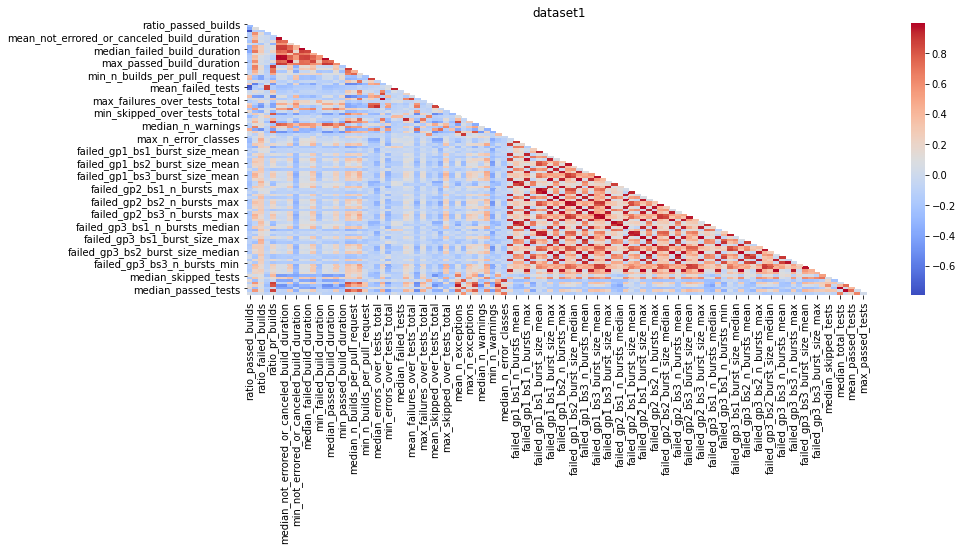

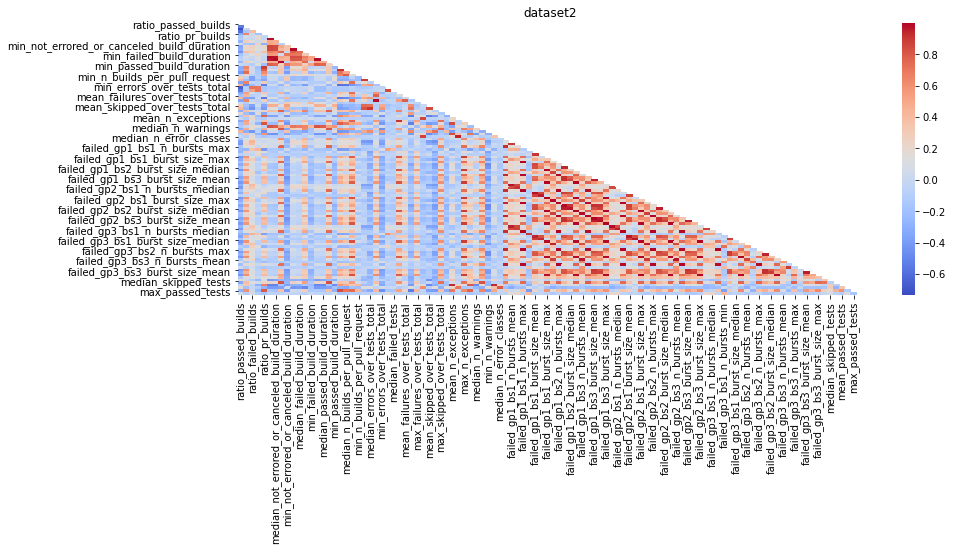

In [453]:
for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

**Do datasets have same columns?**

In [454]:
set(methods_indep_var[methods[0]]).difference(set(methods_indep_var[methods[1]]))

{'max_total_tests', 'median_total_tests'}

### Normal distribution

In [455]:
shapiro(methods_dep_var[methods[0]].post_release_bugs)

ShapiroResult(statistic=0.8320013284683228, pvalue=3.655678483482916e-06)

((array([-2.21906046, -1.85036834, -1.63307165, -1.47338453, -1.34433269,
         -1.23445265, -1.1377432 , -1.05064606, -0.97086677, -0.89683292,
         -0.82741562, -0.76177387, -0.69926181, -0.63937059, -0.58169027,
         -0.52588404, -0.47167018, -0.41880907, -0.3670937 , -0.31634247,
         -0.26639369, -0.2171012 , -0.16833095, -0.11995805, -0.0718644 ,
         -0.02393648,  0.02393648,  0.0718644 ,  0.11995805,  0.16833095,
          0.2171012 ,  0.26639369,  0.31634247,  0.3670937 ,  0.41880907,
          0.47167018,  0.52588404,  0.58169027,  0.63937059,  0.69926181,
          0.76177387,  0.82741562,  0.89683292,  0.97086677,  1.05064606,
          1.1377432 ,  1.23445265,  1.34433269,  1.47338453,  1.63307165,
          1.85036834,  2.21906046]),
  array([ 0.,  0.,  1.,  1.,  1.,  1.,  1.,  1.,  2.,  2.,  2.,  2.,  2.,
          2.,  2.,  2.,  2.,  3.,  4.,  5.,  5.,  6.,  6.,  6.,  6.,  7.,
          7.,  7.,  9.,  9.,  9., 10., 10., 11., 12., 15., 16., 16., 18.,
 

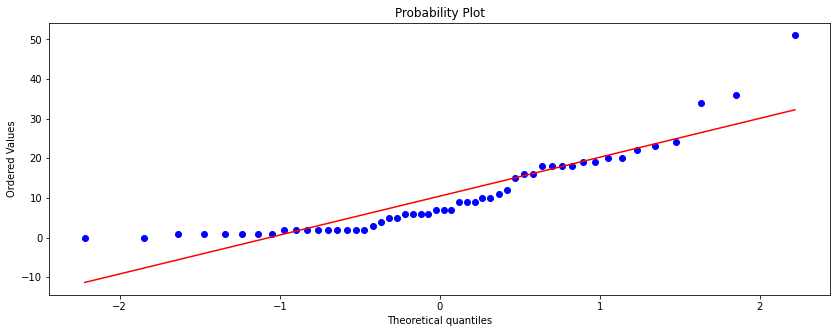

In [456]:
scipy.stats.probplot(methods_dep_var[methods[0]].post_release_bugs, dist="norm", plot=plt)

In [457]:
method_normal_distributed_features = {}
for method in methods:
    shapiro_feat = methods_indep_var[method].apply(lambda x: shapiro(x)).T
    shapiro_feat.columns = ["statistic", "pval"]
    normal_feat = methods_indep_var[method].apply(lambda x: normaltest(x)).T
    normal_feat.columns = ["statistic", "pval"]
    method_normal_distributed_features[method] = list(shapiro_feat[shapiro_feat.pval > 0.95].index)\
    + list(normal_feat[normal_feat.pval > 0.05].index)

<AxesSubplot:ylabel='Frequency'>

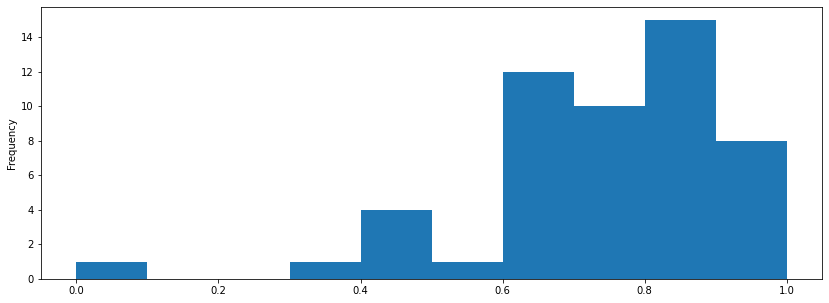

In [458]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="hist")

<Figure size 1008x360 with 0 Axes>

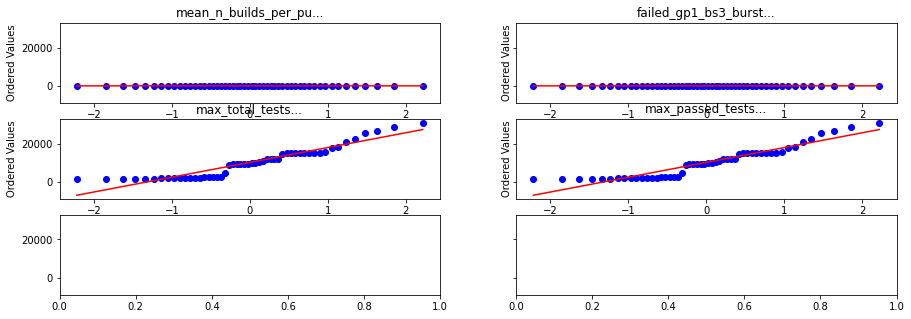

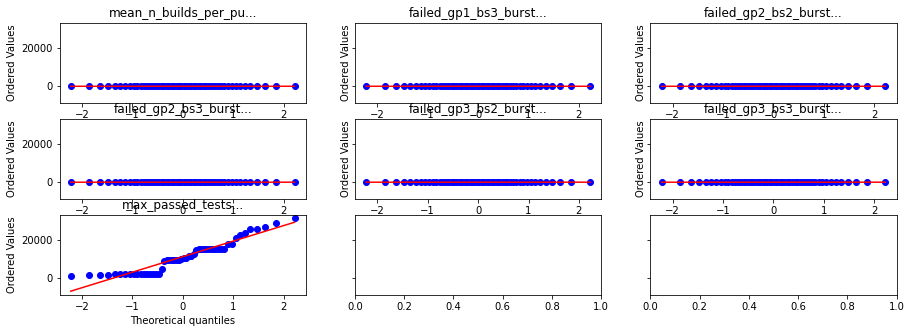

In [459]:
plt.figure()
for method in methods:
    df = methods_indep_var[method]
    normal_features = method_normal_distributed_features[method]
    if(len(normal_features) < 1):
        continue
    fig, axes = plt.subplots(nrows=3, ncols=int(len(normal_features)/3)+1, sharey=True, figsize=(15.0, 5.0))
    axes = axes.flatten()
    for i, feat in enumerate(normal_features):
        scipy.stats.probplot(df[feat], dist="norm", plot=axes[i])
        axes[i].set_title(feat[:20]+"...")
plt.savefig(f"{figure_folder}/dataset_preprocessing/qq-plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

A visual test does not seem to confirm that these features are indeed normally distributed. We conclude that none of our features are normally distributed.

### Correlated features

<Figure size 1008x360 with 0 Axes>

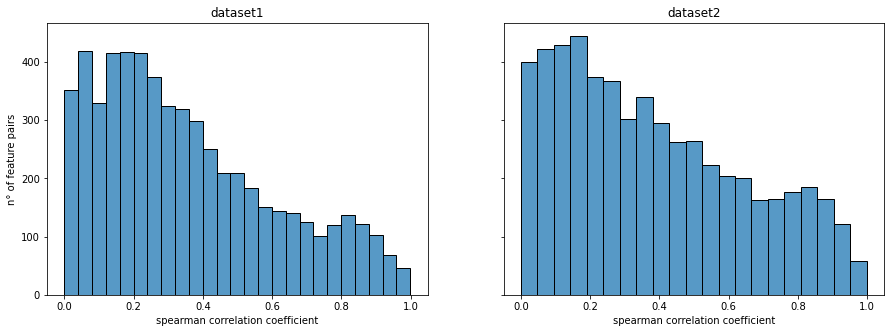

In [460]:
plt.figure()
methods_correlated_features = {}
fig, axes = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15.0, 5.0))
for i, method in enumerate(methods):
    corr_matrix = methods_indep_var[method].corr(method="spearman").abs()
    sol = (corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
                      .stack()
                      .sort_values(ascending=False)).round(decimals = 3)
    methods_correlated_features[method] = sol[sol > 0.8]
    ax = sns.histplot(sol, ax=axes[i])
    ax.set_title(method)
    ax.set(xlabel="spearman correlation coefficient",ylabel="n° of feature pairs")
plt.savefig(f"{figure_folder}/dataset_preprocessing/correlated_feature_dist.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [461]:
methods_correlated_features[methods[1]].head(10)

failed_gp1_bs3_burst_size_max               failed_gp2_bs3_burst_size_max     0.999
failed_gp1_bs3_burst_size_mean              failed_gp2_bs3_burst_size_mean    0.997
max_not_errored_or_canceled_build_duration  max_passed_build_duration         0.997
failed_gp1_bs3_n_bursts_mean                failed_gp2_bs3_n_bursts_mean      0.995
failed_gp1_bs1_burst_size_max               failed_gp2_bs1_burst_size_max     0.995
failed_gp1_bs3_n_bursts_max                 failed_gp2_bs3_n_bursts_max       0.994
failed_gp1_bs2_burst_size_max               failed_gp2_bs2_burst_size_max     0.992
failed_gp2_bs1_burst_size_max               failed_gp2_bs2_burst_size_max     0.990
failed_gp1_bs1_burst_size_max               failed_gp1_bs2_burst_size_max     0.989
failed_gp3_bs1_burst_size_max               failed_gp3_bs2_burst_size_max     0.989
dtype: float64

In [462]:
methods_correlated_features[methods[0]].head(10)

max_total_tests                                max_passed_tests                  0.999
median_total_tests                             median_passed_tests               0.999
max_not_errored_or_canceled_build_duration     max_passed_build_duration         0.998
failed_gp1_bs3_burst_size_max                  failed_gp2_bs3_burst_size_max     0.995
failed_gp1_bs3_n_bursts_mean                   failed_gp2_bs3_n_bursts_mean      0.993
failed_gp1_bs3_burst_size_mean                 failed_gp2_bs3_burst_size_mean    0.992
median_not_errored_or_canceled_build_duration  median_passed_build_duration      0.991
mean_not_errored_or_canceled_build_duration    mean_passed_build_duration        0.990
failed_gp1_bs1_burst_size_max                  failed_gp2_bs1_burst_size_max     0.990
failed_gp2_bs1_burst_size_max                  failed_gp2_bs2_burst_size_max     0.989
dtype: float64

### Correlation with dependent variable
https://dataschool.com/fundamentals-of-analysis/correlation-and-p-value/

We proceed with analysing the correlation of our attributed with the three software quality metricsm
We calculate both types of correlation:
* Pearons (linear)
* Spearman (monotonic, is pearson applied to ranks)

https://support.minitab.com/en-us/minitab-express/1/help-and-how-to/modeling-statistics/regression/supporting-topics/basics/a-comparison-of-the-pearson-and-spearman-correlation-methods/#:~:text=The%20Pearson%20correlation%20evaluates%20the%20linear%20relationship%20between%20two%20continuous%20variables.&text=The%20Spearman%20correlation%20coefficient%20is,evaluate%20relationships%20involving%20ordinal%20variables.

In [463]:
methods_pearson_corr_post_release_bugs = {}
methods_spearman_corr_post_release_bugs = {}
for method in methods:
    data = []
    corr_col = methods_dep_var[method].post_release_bugs
    x = methods_indep_var[method][method_normal_distributed_features[method]].apply(lambda x:\
                                scipy.stats.pearsonr(x, corr_col)).T
    x.columns = ["pearson_corr", "pval"]
    methods_pearson_corr_post_release_bugs[method] = x

    x = methods_indep_var[method].apply(lambda x:\
                                scipy.stats.spearmanr(x, corr_col)).T
    x.columns = ["spearman_corr", "pval"]
    methods_spearman_corr_post_release_bugs[method] = x

**Feature category correlation per each dataset**

In [464]:
feature_categories = ["ratio_(.*)_builds",
                     "(.*)_(.*)_build_duration",
                     "(.*)_n_builds_per_pull_request",
                     "(.*)_errors_over_tests_total",
                     "(.*)_failed_tests",
                     "(.*)_failures_over_tests_total",
                     "(.*)_skipped_over_tests_total",
                     "(.*)_n_exceptions",
                     "(.*)_n_warnings",
                     "(.*)_n_error_classes",
                     #"(.*)_burst_size",
                     "(.*)burst"]

In [465]:
for method in methods:
    x = methods_pearson_corr_post_release_bugs[method]
    x = x[x.pval < 0.05].round(2)
    print(method, "\n", x)

dataset1 
                                 pearson_corr  pval
failed_gp1_bs3_burst_size_mean          0.41   0.0
dataset2 
                                   pearson_corr  pval
failed_gp1_bs3_burst_size_median          0.31  0.02
failed_gp2_bs2_burst_size_mean            0.32  0.02
failed_gp2_bs3_burst_size_median          0.31  0.03
failed_gp3_bs2_burst_size_mean            0.38  0.00
failed_gp3_bs3_burst_size_median          0.38  0.01


In [466]:
for method in methods:
    x = methods_spearman_corr_post_release_bugs[method]
    x = x[x.pval < 0.05].round(2)
    x["abs"] = x.spearman_corr.abs()
    print(method, "\n", x.sort_values(by="abs", ascending=False))

dataset1 
                                             spearman_corr  pval   abs
max_failed_tests                                     0.62  0.00  0.62
failed_gp2_bs3_n_bursts_max                          0.59  0.00  0.59
failed_gp1_bs2_n_bursts_max                          0.58  0.00  0.58
failed_gp1_bs3_n_bursts_max                          0.57  0.00  0.57
failed_gp2_bs2_n_bursts_max                          0.56  0.00  0.56
failed_gp3_bs3_n_bursts_max                          0.55  0.00  0.55
failed_gp3_bs2_n_bursts_max                          0.55  0.00  0.55
failed_gp3_bs1_n_bursts_max                          0.55  0.00  0.55
mean_failed_tests                                    0.55  0.00  0.55
failed_gp3_bs3_burst_size_max                        0.54  0.00  0.54
failed_gp2_bs3_burst_size_max                        0.54  0.00  0.54
failed_gp2_bs1_n_bursts_max                          0.54  0.00  0.54
failed_gp3_bs3_burst_size_mean                       0.53  0.00  0.53
failed_gp

In [467]:
import re
for cat in feature_categories:
    print("-"*10)
    print(cat)
    for method in methods:
        x = methods_spearman_corr_post_release_bugs[method]
        x = x[x.pval < 0.05].round(2)
        print(method, "\n", x[[True if re.search(cat, s) else False for s in x.index]]\
              .spearman_corr.sort_values(ascending=False).to_latex())

----------
ratio_(.*)_builds
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_canceled\_builds &           0.28 \\
ratio\_passed\_builds   &          -0.28 \\
\bottomrule
\end{tabular}

dataset2 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
ratio\_canceled\_builds &           0.31 \\
ratio\_failed\_builds   &           0.29 \\
ratio\_passed\_builds   &          -0.40 \\
\bottomrule
\end{tabular}

----------
(.*)_(.*)_build_duration
dataset1 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
max\_failed\_build\_duration                  &           0.37 \\
min\_not\_errored\_or\_canceled\_build\_duration &          -0.36 \\
\bottomrule
\end{tabular}

dataset2 
 \begin{tabular}{lr}
\toprule
{} &  spearman\_corr \\
\midrule
max\_failed\_build\_duration                  &           0.44 \\
min\_not\_errored\_or\_canceled\_build\_duration &          -0.31 \\
\bottomrule
\end{tabular}

----------
(.*)_n_builds_per_pull_request
dat

In [468]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr

max_failed_tests                              0.604831
failed_gp1_bs2_n_bursts_max                   0.574728
failed_gp2_bs2_n_bursts_max                   0.563983
failed_gp2_bs3_n_bursts_max                   0.554533
mean_failed_tests                             0.553903
failed_gp3_bs2_n_bursts_max                   0.550634
failed_gp1_bs3_n_bursts_max                   0.542157
failed_gp3_bs1_n_bursts_max                   0.538328
failed_gp2_bs2_n_bursts_mean                  0.535368
failed_gp2_bs1_n_bursts_mean                  0.528115
failed_gp2_bs3_burst_size_max                 0.522045
failed_gp2_bs1_n_bursts_max                   0.521132
failed_gp2_bs2_burst_size_max                 0.520695
failed_gp1_bs2_burst_size_max                 0.518584
failed_gp3_bs3_n_bursts_max                   0.518110
failed_gp3_bs3_burst_size_max                 0.515512
failed_gp3_bs2_burst_size_max                 0.513054
failed_gp3_bs2_n_bursts_mean                  0.512443
failed_gp1

In [469]:
spearman_corr[[col for col in spearman_corr.index if re.search("(.*)_(.*)_build_duration", col)]]

max_failed_build_duration                     0.442413
min_not_errored_or_canceled_build_duration   -0.313496
Name: spearman_corr, dtype: float64

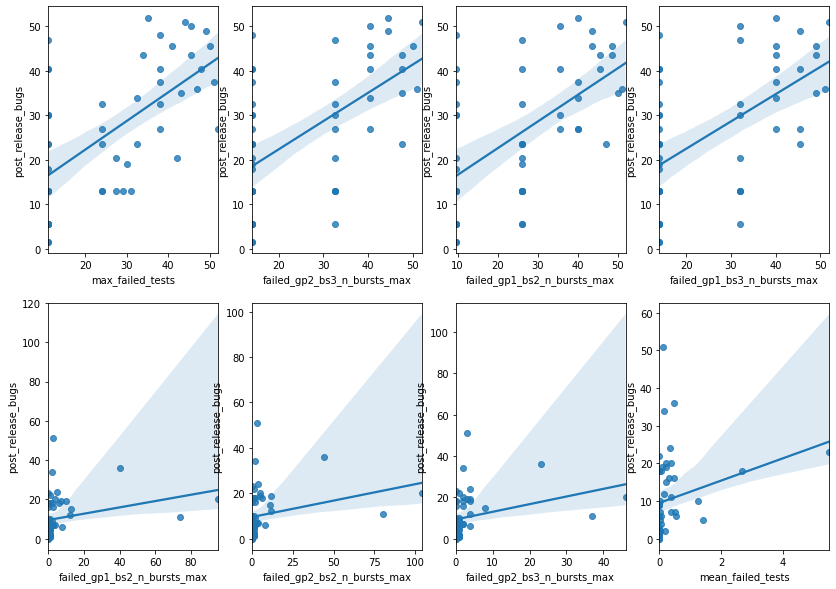

In [470]:
fig, axes = plt.subplots(nrows=2, ncols=4, figsize=(14.0, 10.0))
axes = axes.flatten()

corr = methods_spearman_corr_post_release_bugs[methods[0]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for i in range(4):
    feature = spearman_corr.index[i]
    sns.regplot(x=methods_indep_var[methods[0]][feature].rank(),
                   y=methods_dep_var[methods[0]].post_release_bugs.rank(), ax=axes[i])
    
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
for j in range(i+1, 8):
    feature = spearman_corr.index[j-i]
    sns.regplot(x=methods_indep_var[methods[1]][feature],
                   y=methods_dep_var[methods[1]].post_release_bugs, ax=axes[j])

df = methods_spearman_corr_post_release_bugs[methods[0]].sort_values()
df = df.reindex(df.abs().sort_values(ascending=False).index)
ax = df[[col for col in df.index if not "burst" in col]].head(20).plot(kind="bar")
ax.set_title("Top 20 spearman rank correlations with post release bugs (no burst metrics)")

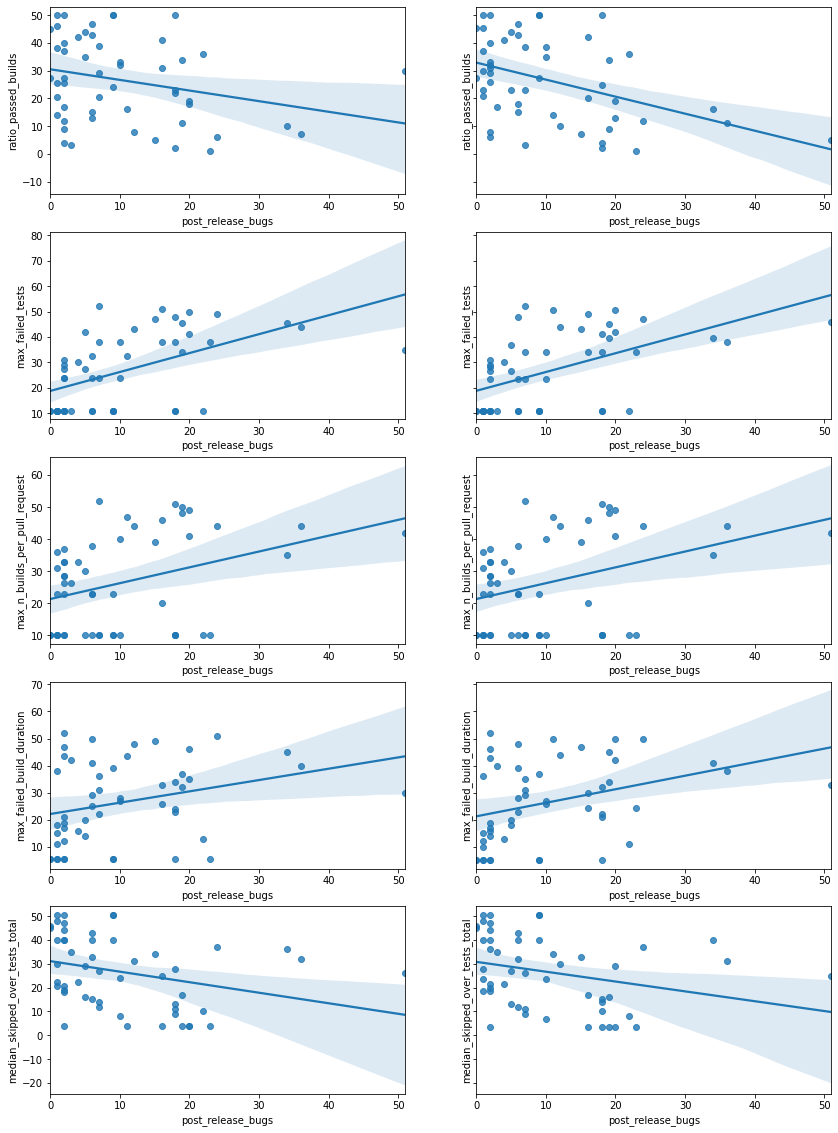

In [471]:
columns = ["ratio_passed_builds", "max_failed_tests",\
          "max_n_builds_per_pull_request", "max_failed_build_duration", "median_skipped_over_tests_total"]
fig, axes = plt.subplots(nrows=len(columns), ncols=2, sharey='row', figsize=(14.0, 4*len(columns)))
axes = axes.flatten()
i = 0
for col in columns:
    df_ind = methods_indep_var[methods[0]]
    df_dep = methods_dep_var[methods[0]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1
    df_ind = methods_indep_var[methods[1]]
    df_dep = methods_dep_var[methods[1]]
    sns.regplot(y=df_ind[col].rank(), x=df_dep.post_release_bugs, ax=axes[i])
    i+=1

In [472]:
corr = methods_spearman_corr_post_release_bugs[methods[1]]
corr = corr[corr.pval < 0.05]
spearman_corr = corr.spearman_corr
spearman_corr = spearman_corr.reindex(spearman_corr.abs().sort_values(ascending=False).index)
spearman_corr[spearman_corr.abs() > 0.35].index

Index(['max_failed_tests', 'failed_gp1_bs2_n_bursts_max',
       'failed_gp2_bs2_n_bursts_max', 'failed_gp2_bs3_n_bursts_max',
       'mean_failed_tests', 'failed_gp3_bs2_n_bursts_max',
       'failed_gp1_bs3_n_bursts_max', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp2_bs2_n_bursts_mean', 'failed_gp2_bs1_n_bursts_mean',
       'failed_gp2_bs3_burst_size_max', 'failed_gp2_bs1_n_bursts_max',
       'failed_gp2_bs2_burst_size_max', 'failed_gp1_bs2_burst_size_max',
       'failed_gp3_bs3_n_bursts_max', 'failed_gp3_bs3_burst_size_max',
       'failed_gp3_bs2_burst_size_max', 'failed_gp3_bs2_n_bursts_mean',
       'failed_gp1_bs3_burst_size_max', 'failed_gp1_bs2_n_bursts_mean',
       'failed_gp2_bs1_burst_size_max', 'failed_gp1_bs1_burst_size_max',
       'failed_gp1_bs1_n_bursts_max', 'failed_gp3_bs1_burst_size_max',
       'failed_gp3_bs3_burst_size_mean', 'failed_gp3_bs1_n_bursts_mean',
       'failed_gp3_bs3_n_bursts_mean', 'failed_gp3_bs2_burst_size_mean',
       'failed_gp2_bs3_n_

cols = ['max_failed_tests', 'max_n_builds_per_pull_request',
       'mean_failed_tests', 'failed_gp3_bs1_n_bursts_max',
       'failed_gp3_bs3_burst_size_max', 'max_failed_build_duration',
       'max_n_error_classes', 'median_skipped_over_tests_total',
       'failed_gp1_bs1_burst_size_mean', 'max_n_exceptions',
       'ratio_passed_builds','mean_n_builds_per_pull_request',
        'min_skipped_over_tests_total', 'max_failures_over_tests_total']
df = methods_indep_var[methods[1]][cols].corr(method="spearman")
cols = []
matrix = np.triu(df) 
ax = sns.heatmap(df, cmap= 'coolwarm', mask=matrix, annot=True) 
#ax.set_title(method) 
plt.show()

<AxesSubplot:>

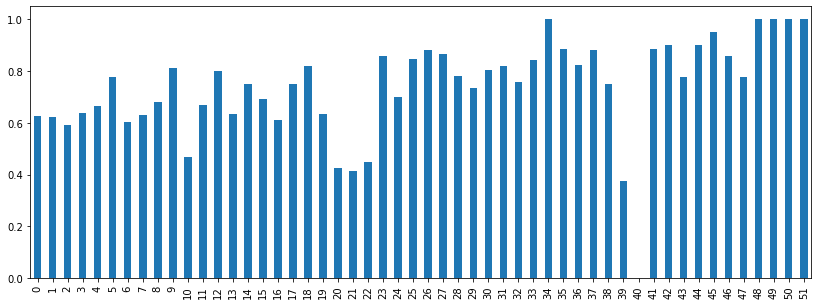

In [473]:
methods_indep_var[methods[1]].ratio_passed_builds.plot(kind="bar")

<AxesSubplot:>

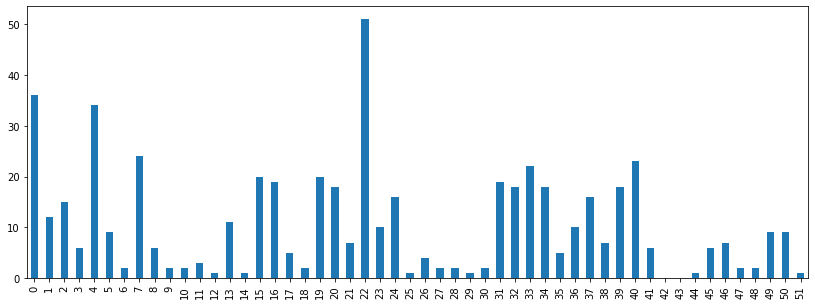

In [474]:
methods_dep_var[methods[1]].post_release_bugs.plot(kind="bar")

<AxesSubplot:>

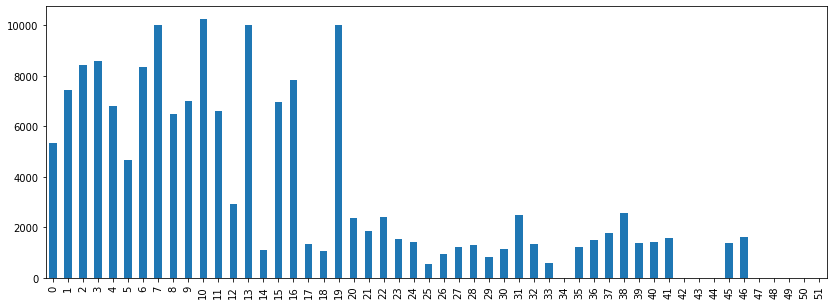

In [475]:
methods_indep_var[methods[1]].max_failed_build_duration.plot(kind="bar")

In [476]:
methods_indep_var[methods[1]].max_failed_build_duration.corr(\
                        methods_indep_var[methods[1]].min_not_errored_or_canceled_build_duration, method="spearman")

-0.29091316362019837

**Remove highly correlated features?**

In [477]:
methods_corr_cols_to_remove = {}
for method in methods:
    cols_to_remove = set()
    print(method, len(methods_correlated_features[method]))
    corr_matrix = methods_indep_var[method].corr().abs()
    upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
    methods_corr_cols_to_remove[method] = [column for column in upper.columns if any(upper[column] > 0.95)]

dataset1 474
dataset2 566


In [478]:
for method in methods:
    cols_to_remove = methods_corr_cols_to_remove[method]
    methods_indep_var[method] = methods_indep_var[method].drop(columns=cols_to_remove, errors="ignore")
    print(methods_indep_var[method].shape)

(52, 60)
(52, 66)


for method in methods:
    matrix = np.triu(methods_indep_var[method].corr())
    ax = sns.heatmap(methods_indep_var[method].corr(), cmap= 'coolwarm', mask=matrix)
    ax.set_title(method)
    plt.show()

### Play with feature selection

In [555]:
# example of correlation feature selection for numerical data
from sklearn.datasets import make_regression
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_regression, RFECV
from sklearn.model_selection import KFold, LeaveOneOut, GridSearchCV
from sklearn.linear_model import LinearRegression, LogisticRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.preprocessing import PolynomialFeatures
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.dummy import DummyRegressor
from sklearn.isotonic import IsotonicRegression
from sklearn.dummy import DummyClassifier
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score, roc_auc_score
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.metrics import f1_score, precision_score, make_scorer
from sklearn.svm import SVR
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsClassifier, KNeighborsRegressor
from sklearn.model_selection import RandomizedSearchCV
from sklearn.naive_bayes import GaussianNB
from sklearn.decomposition import PCA
from scipy.stats import ranksums

In [556]:
regression_mask = mask_to_use
cross_validation_strategy = KFold(5, shuffle=True, random_state=1)

In [557]:
method_x_train = {}
method_y_train = {}
method_train_columns = {}
for method in methods:
    X_train = methods_indep_var[method][regression_mask]
    y_train = methods_dep_var[method].post_release_bugs[regression_mask]
    train_columns = X_train.columns
    X_train[X_train.columns] = StandardScaler().fit_transform(X_train)
    method_x_train[method] = X_train
    method_y_train[method] = y_train
    method_train_columns[method] = train_columns

In [611]:
def two_layer_cross_validate_old(model, params_grid, x, y, num_trials, n_splits, scoring=None):
    nested_scores = np.zeros(num_trials)
    for i in range(num_trials):
        inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)
        outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=i)

        # Non_nested parameter search and scoring
        clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
        """clf.fit(method_x_train[methods[1]], method_y_train[methods[1]])
        non_nested_scores[i] = clf.best_score_
        """
        # Nested CV with parameter optimization
        nested_score = cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)
        nested_scores[i] = nested_score.mean()
    return nested_scores

In [ ]:
def two_layer_cross_validate(model, params_grid, x, y, seed, n_splits, scoring=None):
    inner_cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    # Non_nested parameter search and scoring
    clf = GridSearchCV(estimator=model, param_grid=params_grid, cv=inner_cv)
    return cross_val_score(clf, x, y, cv=outer_cv, scoring=scoring)

In [598]:
def outer_layer_cross_validate(model, x, y, seed, n_splits, scoring=None):
    outer_cv = KFold(n_splits=n_splits, shuffle=True, random_state=seed)
    return cross_val_score(model, x, y, cv=outer_cv, scoring=scoring)

In [560]:
def forward_feature_selection(model, X, y, cv=5, scoring="r2"):
    best_performance = np.array([-100])
    added_columns = list()
    feature_performance = {}
    feature_performance["All features"] = perf = cross_val_score(model, X,\
                                   y, cv=cv, scoring=scoring)
    while(True):
        #print("Best perf", best_performance)
        current_perf = best_performance
        curr_col = None
        for col in X.columns:
            if col in added_columns:
                continue
            perf = cross_val_score(model, X[set(added_columns).union(set([col]))],\
                                   y, cv=cv, scoring=scoring)
            #print(col, perf.min())
            if current_perf.min() < perf.min():
                current_perf = perf
                curr_col = col
            elif current_perf.min() == perf.min():
                if current_perf.mean() < perf.mean():
                    current_perf = perf
                    curr_col = col
        if current_perf.min() <= best_performance:
            break
        else:
            best_performance = current_perf.min()
            added_columns.append(curr_col)
            feature_performance[curr_col] = current_perf
            #print(added_columns)
    return added_columns, best_performance, feature_performance

**Regression**

In [561]:
#n_estimators = [int(x) for x in np.linspace(start = 200, stop = 800, num = 4)]
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeRegressor()
method_randomregressor_r2 = {}
method_randomregressor_neg_mean_error = {}
for method in methods:
    method_randomregressor_r2[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 5, "r2")
    method_randomregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_train[method], 5, 5, "neg_mean_absolute_error")

In [562]:
for method in methods:
    print("R2","-"*40)
    print(method, method_randomregressor_r2[method])
    print("Nmae","-"*40)
    print(method, method_randomregressor_neg_mean_error[method])

R2 ----------------------------------------
dataset1 [-0.09021026 -0.77128356 -0.56455706 -0.71460904 -0.02229312]
Nmae ----------------------------------------
dataset1 [ -7.5        -12.9978355   -9.76666667  -8.8         -7.27833333]
R2 ----------------------------------------
dataset2 [-3.07677468 -0.24582888 -0.66641291 -0.56448469 -0.47977495]
Nmae ----------------------------------------
dataset2 [ -9.71363636 -11.5969697  -10.225       -5.83333333  -8.05333333]


In [524]:
method_knn_regr_features = {}
method_knn_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsRegressor(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_regr_features[method] = features
    method_knn_feature_performance = feature_performance

--------------------
dataset1 ['max_n_exceptions', 'max_failed_tests', 'mean_failed_tests', 'min_passed_tests', 'median_errors_over_tests_total'] 0.2027950481430537
--------------------
--------------------
dataset2 ['max_failed_tests', 'median_n_exceptions', 'min_skipped_over_tests_total', 'failed_gp3_bs1_n_bursts_min'] 0.19256893073301962
--------------------


<Figure size 1008x360 with 0 Axes>

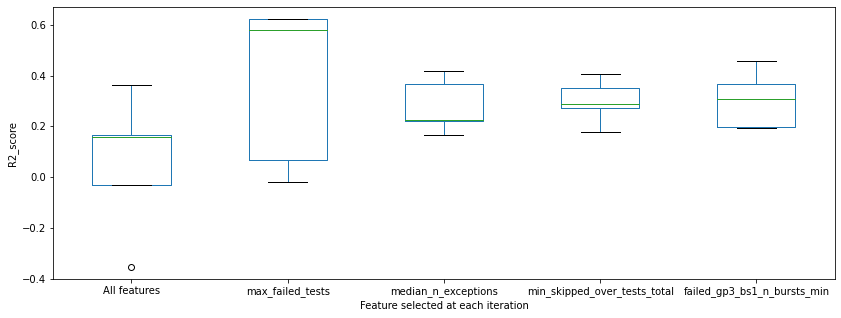

In [563]:
plt.figure()
ax = pd.DataFrame(method_knn_feature_performance).plot(kind="box")
ax.set(ylabel="R2_score", xlabel="Feature selected at each iteration")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [564]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsRegressor()
method_knregressor_r2 = {}
method_knregressor_neg_mean_error = {}
for method in methods:
    x = method_x_train[method][method_knn_regr_features[method]]
    method_knregressor_r2[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 5, "r2")
    method_knregressor_neg_mean_error[method] = \
        two_layer_cross_validate(model, params_grid, x, method_y_train[method], 5, 5, "neg_mean_absolute_error")

In [565]:
for method in methods:
    print(method, method_knregressor_r2[method])
    print(method, method_knregressor_neg_mean_error[method])

dataset1 [0.20696741 0.24752132 0.27139541 0.79228447 0.18112811]
dataset1 [-5.43636364 -8.78181818 -6.24285714 -2.91       -8.21      ]
dataset2 [0.47751338 0.19710591 0.29991722 0.11358444 0.27753026]
dataset2 [-4.31818182 -9.52727273 -6.61428571 -5.5        -6.33      ]


In [566]:
method_lin_regr_features = {}
method_lin_regr_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(LinearRegression(), method_x_train[method],\
                                           method_y_train[method], cv=cross_validation_strategy)
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_lin_regr_features[method] = features
    method_lin_regr_feature_performance = feature_performance

--------------------
dataset1 ['ratio_passed_builds'] -0.041923936673557094
--------------------
--------------------
dataset2 ['ratio_passed_builds', 'failed_gp1_bs2_n_bursts_mean', 'median_n_error_classes', 'failed_gp3_bs3_n_bursts_min'] 0.10973878853969832
--------------------


<Figure size 1008x360 with 0 Axes>

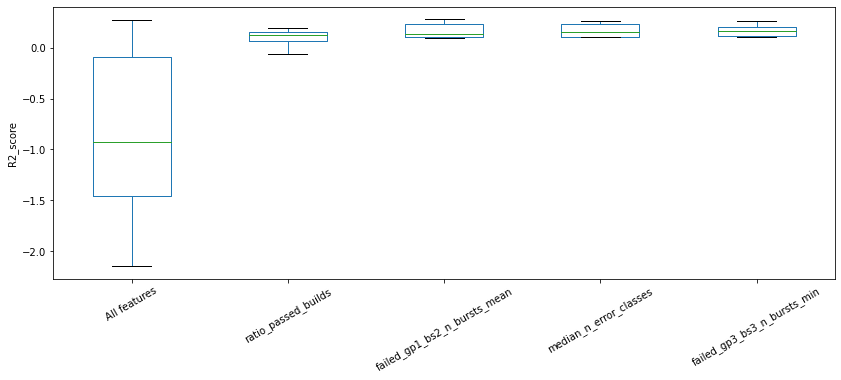

In [567]:
plt.figure()
ax = pd.DataFrame(method_lin_regr_feature_performance).plot(kind="box")
ax.set(ylabel="R2_score")
ax.set_xticklabels(ax.get_xticklabels(),rotation=30)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/linreg_feature_selection_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)
plt.show()

In [568]:
method_linregression_r2 = {}
method_linregression_nmae = {}
for method in methods:
    features = method_lin_regr_features[method]
    method_linregression_r2[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 5, scoring="r2")
    method_linregression_nmae[method] = outer_layer_cross_validate(LinearRegression(), method_x_train[method][features],\
                    method_y_train[method], 5, 5, scoring="neg_mean_absolute_error")

In [569]:
for method in methods:
    print("R2","-"*40)
    print(method, method_linregression_r2[method])
    print("Nmae","-"*40)
    print(method, method_linregression_nmae[method])

R2 ----------------------------------------
dataset1 [-0.04192394 -0.03519725 -0.03667337  0.04276831  0.01935395]
Nmae ----------------------------------------
dataset1 [-7.57391485 -7.32817707 -7.58675717 -5.87544292 -9.33663344]
R2 ----------------------------------------
dataset2 [0.10973879 0.17012583 0.11473601 0.26629612 0.20437587]
Nmae ----------------------------------------
dataset2 [-6.15616591 -7.56718266 -7.08834552 -5.53877379 -7.81835363]


is_small = y_train < y_train.quantile(.25)
is_large = y_train > y_train.quantile(.75)
is_medium = ~(is_small | is_large)

y_quantiles = y_train.mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')

<Figure size 1008x360 with 0 Axes>

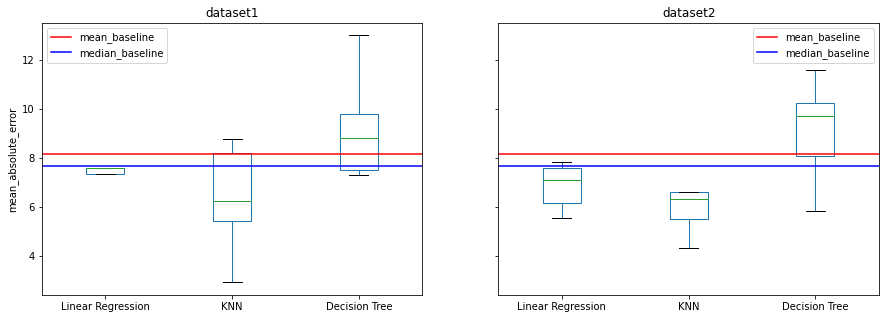

In [570]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_nmae,
          "KNN": method_knregressor_neg_mean_error,
          "Decision Tree": method_randomregressor_neg_mean_error
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = -score[method]
    ax = pd.DataFrame(data).plot(kind="box", showfliers=False, ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=mean_absolute_error(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="median_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="mean_absolute_error")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_neg_mean_absolute_error.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

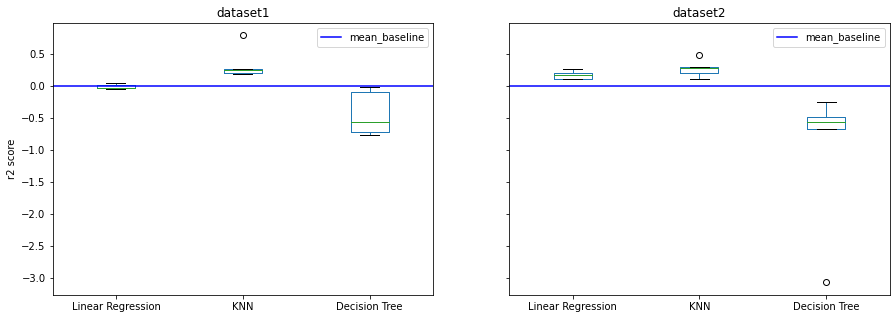

In [571]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"Linear Regression":method_linregression_r2,
          "KNN": method_knregressor_r2, 
          "Decision Tree": method_randomregressor_r2
         }
for i, method in enumerate(methods):
    data = {}
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    y = method_y_train[method]
    #ax.axhline(y=r2_score(DummyRegressor(strategy="mean").fit(x, y).predict(y), y),color='r', label="mean_baseline")
    ax.axhline(y=r2_score(DummyRegressor(strategy="median").fit(x, y).predict(y), y),color='b', label="mean_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="r2 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/regression_r2.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

### Quantiles

method_y_quantiles_train = {}
for method in methods:
    y_train = method_y_train[method]
    is_xsmall = y_train <= y_train.quantile(.16)
    is_small = (y_train > y_train.quantile(.16)) & (y_train <= y_train.quantile(.5))
    is_large = y_train >= y_train.quantile(.75)
    is_medium = ~(is_small | is_large | is_xsmall)

    y_quantiles = y_train.mask(is_xsmall, "xsmall").mask(is_small, 'small').mask(is_large, 'large').mask(is_medium, 'medium')
    print(y_quantiles.value_counts())
    method_y_quantiles_train[method] = y_quantiles

In [627]:
method_y_quantiles_train = {}
for method in methods:
    y_train = method_y_train[method]
    print("33", y_train.quantile(.33))
    print("66", y_train.quantile(.66))
    is_small = y_train <= y_train.quantile(.33)
    is_large = y_train >= y_train.quantile(.66)
    is_medium = ~(is_small | is_large)

    y_quantiles = y_train.mask(is_small, 0).mask(is_medium, 1).mask(is_large, 2)
    method_y_quantiles_train[method] = y_quantiles

33 2.830000000000002
66 11.660000000000004
33 2.830000000000002
66 11.660000000000004


In [628]:
method_y_quantiles_train[methods[0]].value_counts()

2.0    18
0.0    17
1.0    17
Name: post_release_bugs, dtype: int64

In [629]:
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_dtclassifier_quantiles_f1 = {}
method_dtclassifier_quantiles_accuracy = {}
for method in methods:
    method_dtclassifier_quantiles_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "f1_macro")
    method_dtclassifier_quantiles_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_quantiles_train[method], 5, 5, "accuracy")

In [630]:
for method in methods:
    print(method, method_dtclassifier_quantiles_accuracy[method])
    print(method, method_dtclassifier_quantiles_f1[method])

dataset1 [0.54545455 0.72727273 0.5        0.8        0.5       ]
dataset1 [0.65714286 0.71111111 0.71428571 0.50793651 0.58730159]
dataset2 [0.54545455 0.36363636 0.4        0.5        0.3       ]
dataset2 [0.38888889 0.63095238 0.35714286 0.48677249 0.3952381 ]


In [631]:
method_knn_quantiles_features = {}
method_knn_quantiles_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_quantiles_train[method], cv=cross_validation_strategy, scoring="f1_macro")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_quantiles_features[method] = features
    method_knn_quantiles_feature_performance[method] = feature_performance

--------------------
dataset1 ['median_total_tests', 'max_failed_tests', 'mean_failed_tests'] 0.5857142857142857
--------------------
--------------------
dataset2 ['failed_gp1_bs2_burst_size_mean', 'max_failed_tests', 'failed_gp3_bs1_n_bursts_min'] 0.4952380952380953
--------------------


In [632]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_quantiles_f1 = {}
method_knn_quantiles_accuracy = {}
for method in methods:
    x = method_x_train[method][method_knn_quantiles_features[method]]
    print(x.columns)
    method_knn_quantiles_f1[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_quantiles_train[method], 5, 5, "f1_macro")
    method_knn_quantiles_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_quantiles_train[method], 5, 5, "accuracy")

Index(['median_total_tests', 'max_failed_tests', 'mean_failed_tests'], dtype='object')
Index(['failed_gp1_bs2_burst_size_mean', 'max_failed_tests',
       'failed_gp3_bs1_n_bursts_min'],
      dtype='object')


In [633]:
for method in methods:
    print(method, method_knn_quantiles_f1[method])
    print(method, method_knn_quantiles_accuracy[method])

dataset1 [0.59047619 0.33846154 0.3952381  0.61111111 0.70714286]
dataset1 [0.63636364 0.45454545 0.4        0.6        0.7       ]
dataset2 [0.42626263 0.81904762 0.65185185 0.41269841 0.3968254 ]
dataset2 [0.45454545 0.81818182 0.7        0.5        0.4       ]


<Figure size 1008x360 with 0 Axes>

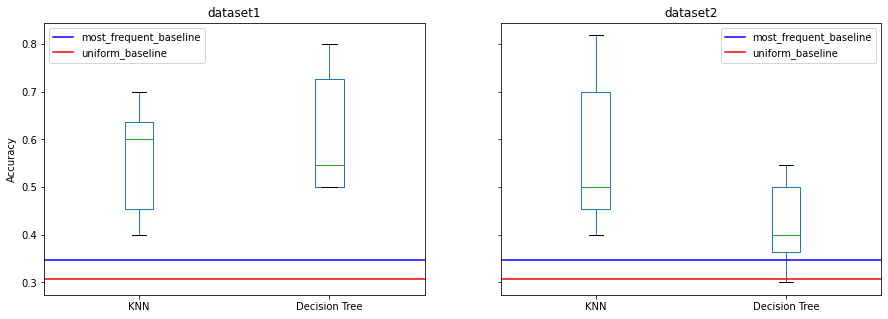

In [634]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"KNN": method_knn_quantiles_accuracy, 
          "Decision Tree": method_dtclassifier_quantiles_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_quantiles = method_y_quantiles_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_quantiles).predict(y_quantiles), y_quantiles), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_quantiles).predict(y_quantiles), y_quantiles), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/quantile_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

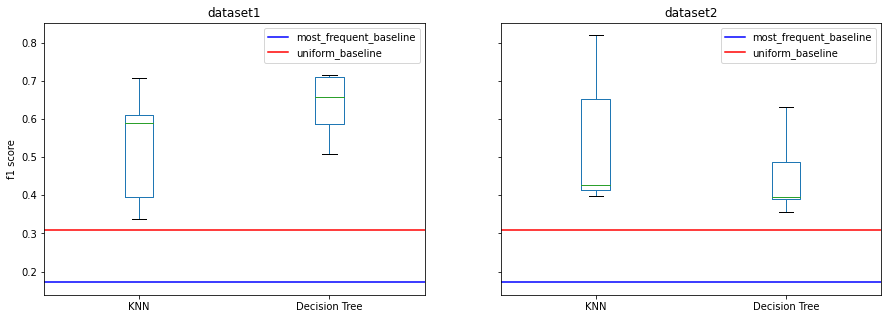

In [635]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"KNN": method_knn_quantiles_f1, 
          "Decision Tree": method_dtclassifier_quantiles_f1}
for i, method in enumerate(methods):
    data = {}
    y_quantiles = method_y_quantiles_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_quantiles).predict(y_quantiles), y_quantiles, average="macro"), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_quantiles).predict(y_quantiles), y_quantiles, average="macro"), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/quantile_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpreting DT for dataset1**

<Figure size 1008x360 with 0 Axes>

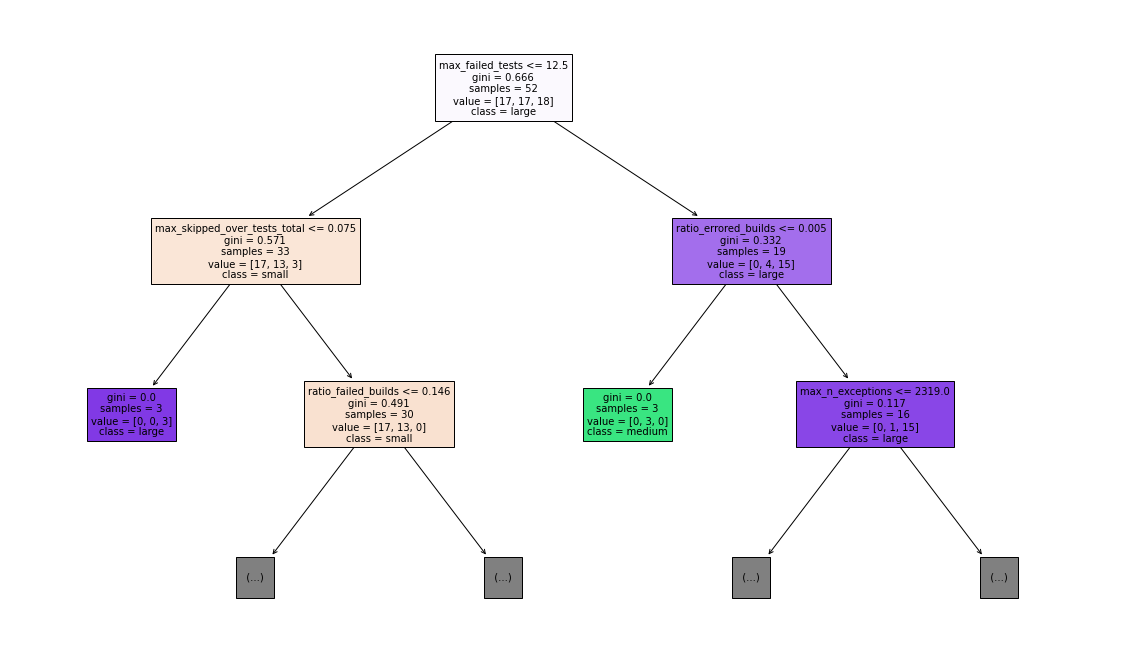

In [581]:
plt.figure()
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[0]], method_y_quantiles_train[methods[0]])
fig, ax = plt.subplots(figsize=(20, 12))
plot_tree(dt, feature_names=method_x_train[methods[0]].columns, max_depth=2, filled=True, class_names=["small", "medium", "large"], fontsize=10)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_method0.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

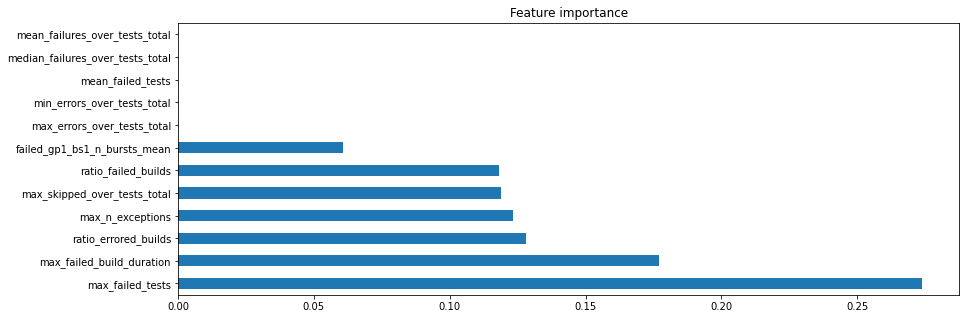

In [582]:
plt.figure()
ax = pd.Series(dt.feature_importances_, method_x_train[methods[0]].columns).sort_values(ascending=False).head(12).plot(kind="barh")
ax.set_title("Feature importance")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_f_impo_method0.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpreting KNN for method1**

<ipython-input-584-fe6bac1e2215>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["classes"] = method_y_quantiles_train[m].map({0:"small", 1:"medium", 2:"large"})
/Users/alexincerti/Library/Python/3.8/lib/python/site-packages/seaborn/distributions.py:305: UserWarning: Dataset has 0 variance; skipping density estimate.
  warnings.warn(msg, UserWarning)


<Figure size 1008x360 with 0 Axes>

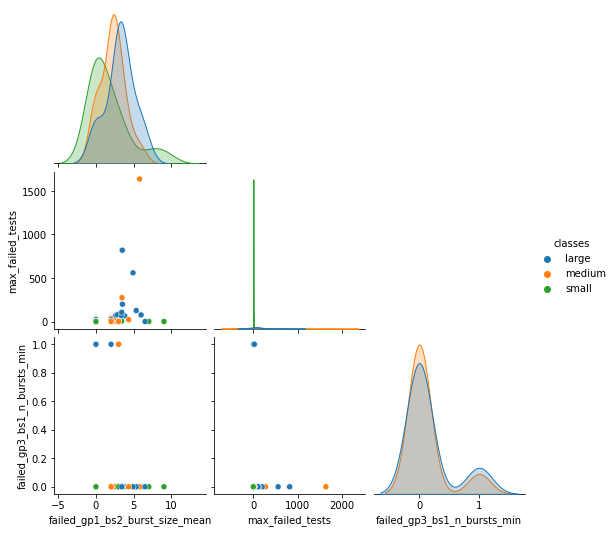

In [584]:
plt.figure()
m = methods[1]
df = methods_indep_var[m][method_knn_quantiles_features[m]]
df["classes"] = method_y_quantiles_train[m].map({0:"small", 1:"medium", 2:"large"})
"""sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                hue="quantiles", palette="deep")"""
sns.pairplot(df, hue="classes",corner=True)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_method1_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

### Binary

In [585]:
method_y_bin_train = {}
for method in methods:
    print(method_y_train[method].median())
    method_y_bin_train[method] = method_y_train[method] > method_y_train[method].median()

7.0
7.0


In [619]:
min_samples_leaf = [1,2,3,4]
max_depth = [4,8,16,None]
params_grid = {'min_samples_leaf': min_samples_leaf,
               "max_depth" : max_depth
              }

model = DecisionTreeClassifier()
method_randomclassifier_binary_f1 = {}
method_dtclassifier_binary_accuracy = {}
method_dtclassifier_binary_auc = {}
for method in methods:
    method_randomclassifier_binary_f1[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 5, "f1")
    method_dtclassifier_binary_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 5, "accuracy")
    method_dtclassifier_binary_auc[method] = \
            two_layer_cross_validate(model, params_grid, method_x_train[method], method_y_bin_train[method], 5, 5, "roc_auc")

In [620]:
for method in methods:
    print(method, "F1", method_dtclassifier_binary_accuracy[method], method_dtclassifier_binary_accuracy[method].mean())
    print(method, "Accuracy", method_randomclassifier_binary_f1[method], method_randomclassifier_binary_f1[method].mean())
    print(method, method_dtclassifier_binary_auc[method])

dataset1 F1 [0.54545455 0.54545455 0.5        0.6        0.8       ] 0.5981818181818183
dataset1 Accuracy [0.54545455 0.61538462 0.28571429 0.8        0.66666667] 0.5826440226440226
dataset1 [0.55       0.53333333 0.45833333 0.625      0.76190476]
dataset2 F1 [0.63636364 0.45454545 0.6        0.8        0.7       ] 0.6381818181818183
dataset2 Accuracy [0.54545455 0.36363636 0.25       0.83333333 0.57142857] 0.5127705627705628
dataset2 [0.55       0.73333333 0.39583333 0.77083333 0.78571429]


In [621]:
method_knn_bin_features = {}
method_knn_bin_feature_performance = {}
for method in methods:
    features, score, feature_performance = forward_feature_selection(KNeighborsClassifier(), method_x_train[method],\
                                           method_y_bin_train[method], cv=cross_validation_strategy, scoring="f1")
    print("-"*20)
    print(method, features, score)
    print("-"*20)
    method_knn_bin_features[method] = features
    method_knn_bin_feature_performance[method] = feature_performance

--------------------
dataset1 ['failed_gp1_bs1_n_bursts_max'] 0.5454545454545454
--------------------
--------------------
dataset2 ['max_n_builds_per_pull_request', 'failed_gp1_bs1_burst_size_median', 'failed_gp1_bs2_burst_size_median', 'ratio_errored_builds'] 0.6153846153846153
--------------------


In [622]:
params_grid = {'n_neighbors': [int(x) for x in np.linspace(start = 1, stop = 10, num = 5)],
              'p': [1,2,3]}
model = KNeighborsClassifier()
method_knn_f1 = {}
method_knn_accuracy = {}
method_knn_auc = {}
for method in methods:
    x = method_x_train[method][method_knn_bin_features[method]]
    print(x.columns)
    method_knn_f1[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 5, "f1")
    method_knn_accuracy[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 5, "accuracy")
    method_knn_auc[method] = \
            two_layer_cross_validate(model, params_grid, x, method_y_bin_train[method], 5, 5, "roc_auc")


Index(['failed_gp1_bs1_n_bursts_max'], dtype='object')
Index(['max_n_builds_per_pull_request', 'failed_gp1_bs1_burst_size_median',
       'failed_gp1_bs2_burst_size_median', 'ratio_errored_builds'],
      dtype='object')


In [623]:
for method in methods:
    print(method, "F1", method_knn_f1[method], method_knn_f1[method].mean())
    print(method, "Accuracy", method_knn_accuracy[method], method_knn_accuracy[method].mean())
    print(method, method_knn_auc[method])

dataset1 F1 [0.6        0.54545455 0.66666667 0.90909091 0.33333333] 0.610909090909091
dataset1 Accuracy [0.63636364 0.54545455 0.8        0.9        0.6       ] 0.6963636363636364
dataset1 [0.66666667 0.63333333 0.79166667 0.875      0.66666667]
dataset2 F1 [0.6        0.54545455 0.75       0.66666667 0.66666667] 0.6457575757575758
dataset2 Accuracy [0.63636364 0.54545455 0.8        0.7        0.8       ] 0.6963636363636363
dataset2 [0.65       0.58333333 0.89583333 0.875      0.85714286]


data = pd.DataFrame({ "maven":[0.88888889, 0.86666667, 0.84166667, 0.82333333, 0.88333333],
                     "all": [0.53636364, 0.67818182, 0.67454545, 0.64,       0.71272727]})
data.plot(kind="box")

data = pd.DataFrame({ "maven":[0.8047619,  0.9047619,  0.84285714, 0.84285714, 0.83809524],
                     "all": [0.69090909, 0.79090909, 0.63636364, 0.69636364, 0.66909091]})
data.plot(kind="box")

<Figure size 1008x360 with 0 Axes>

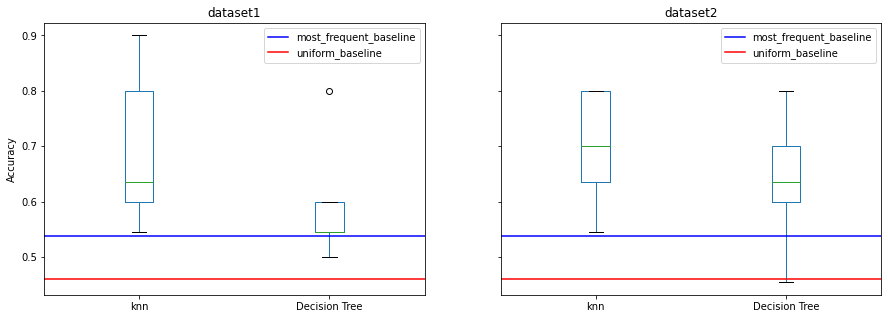

In [624]:
plt.figure()
fig, axes= plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_accuracy, 
          "Decision Tree": method_dtclassifier_binary_accuracy}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=accuracy_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="Accuracy")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_accuracy.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

<Figure size 1008x360 with 0 Axes>

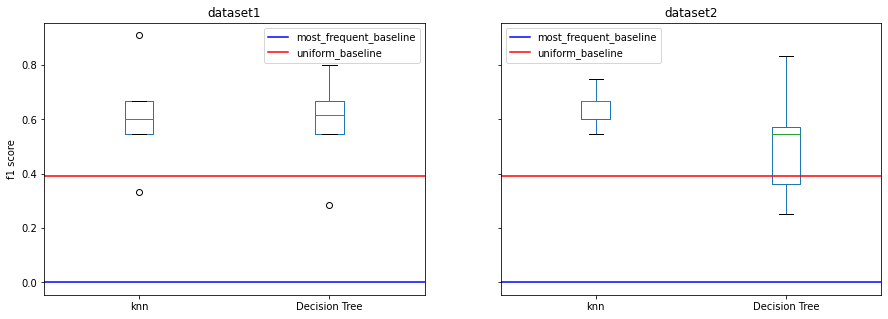

In [625]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_f1, 
          "Decision Tree": method_randomclassifier_binary_f1}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    ax.axhline(y=f1_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=f1_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="f1 score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_f1.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

roc_auc_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin)

<Figure size 1008x360 with 0 Axes>

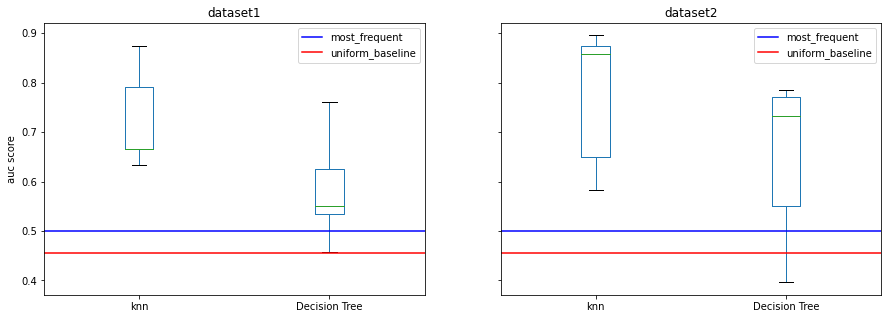

In [626]:
plt.figure()
fig, axes = plt.subplots(nrows=1, ncols=len(methods), sharey=True, figsize=(15.0, 5.0))
scores = {"knn": method_knn_auc, 
          "Decision Tree": method_dtclassifier_binary_auc}
for i, method in enumerate(methods):
    data = {}
    y_bin = method_y_bin_train[method]
    for model, score in scores.items():
        data[model] = score[method]
    ax = pd.DataFrame(data).plot(kind="box", ax=axes[i])
    x = method_x_train[method]
    #ax.axhline(y=roc_auc_score(DummyClassifier(strategy="most_frequent").fit(x, y_bin).predict(y_bin), y_bin), color="b", label="most_frequent_baseline")
    ax.axhline(y=0.5, color="b", label="most_frequent")
    ax.axhline(y=roc_auc_score(DummyClassifier(strategy="uniform", random_state=4).fit(x, y_bin).predict(y_bin), y_bin), color="r", label="uniform_baseline")
    ax.legend()
    ax.set_title(method)
    if i == 0:
        ax.set(ylabel="auc score")
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/binary_auc.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**Interpret the models**

[<AxesSubplot:> None None None
 <AxesSubplot:ylabel='failed_gp1_bs1_burst_size_median'> <AxesSubplot:>
 None None <AxesSubplot:ylabel='failed_gp1_bs2_burst_size_median'>
 <AxesSubplot:> <AxesSubplot:> None
 <AxesSubplot:xlabel='max_n_builds_per_pull_request', ylabel='ratio_errored_builds'>
 <AxesSubplot:xlabel='failed_gp1_bs1_burst_size_median'>
 <AxesSubplot:xlabel='failed_gp1_bs2_burst_size_median'>
 <AxesSubplot:xlabel='ratio_errored_builds'>]


<Figure size 720x864 with 0 Axes>

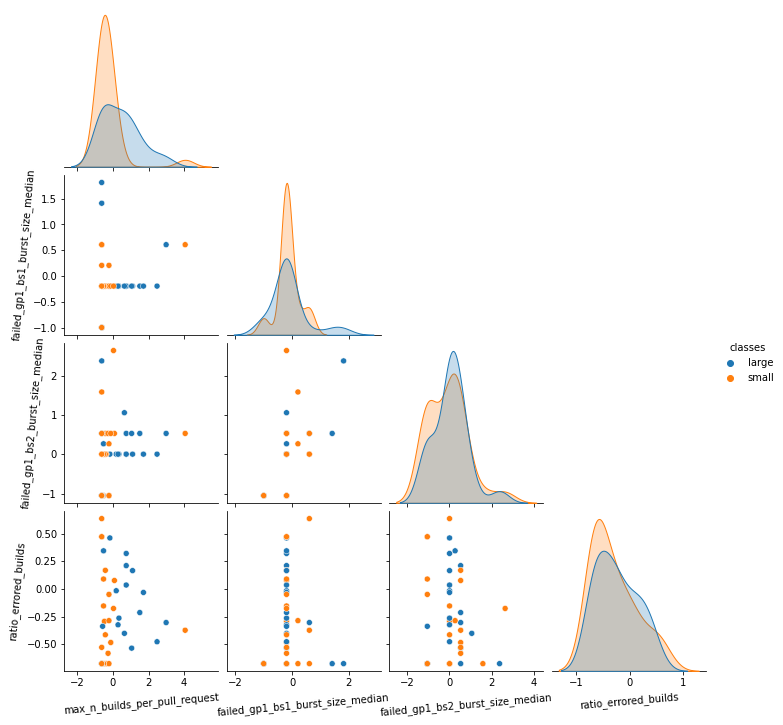

In [519]:
method = methods[1]
plt.figure(figsize=(10, 12))
df = method_x_train[method][method_knn_bin_features[method]]
df = df[(df.ratio_errored_builds < 1)]
#'max_n_builds_per_pull_request', 'failed_gp1_bs1_burst_size_median', 'failed_gp1_bs2_burst_size_median',
df = df[(df.failed_gp1_bs1_burst_size_median < 2)]
#& (df.max_n_builds_per_pull_request < 1)]
df["classes"] = method_y_bin_train[m].map({True:"large", False:"small"})
"""sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                hue="quantiles", palette="deep")"""
g = sns.pairplot(df, hue="classes",corner=True)
print(g.axes.flatten())
for ax in g.axes.flatten():
    if(not ax):
        continue
    # rotate x axis labels
    ax.set_xlabel(ax.get_xlabel(),rotation=5)
    # rotate x axis labels
    ax.set_ylabel(ax.get_ylabel(),rotation=85)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_{method}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

for i, method in enumerate(methods):
    plt.figure()
    df = method_x_train[method][method_knn_bin_features[method]]
    #if i == 0:
        #df = df[(df.max_all_build_duration < 0.00) & (df.max_n_builds_per_pull_request < 5)]
    #if i == 1:
        #df = df[(df.mean_failed_tests < 0.05) & (df.max_n_builds_per_pull_request < 1)]
    df["classes"] = method_y_bin_train[m].map({True:"large", False:"small"})
    """sns.scatterplot(data=df, x="max_failed_build_duration", y="failed_gp3_bs3_burst_size_mean", marker="o",\
                    hue="quantiles", palette="deep")"""
    sns.pairplot(df, hue="classes",corner=True)
    plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/knn_{method}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

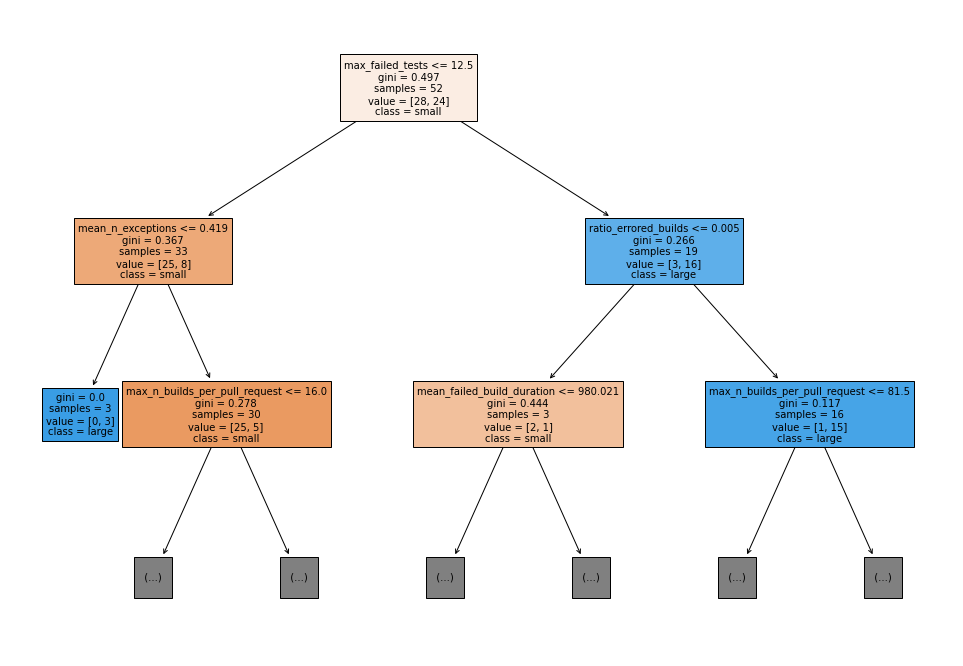

In [520]:
from sklearn.tree import plot_tree
dt = DecisionTreeClassifier()
dt.fit(methods_indep_var[methods[0]], method_y_bin_train[methods[0]])
fig, ax = plt.subplots(figsize=(17, 12))
plot_tree(dt, feature_names=method_x_train[methods[0]].columns,max_depth=2,filled=True, class_names=["small", "large"], fontsize=10)
plt.savefig(f"{figure_folder}/machine_learning_results/{mask_name}/dt_{methods[0]}_bin_plot.png", transparent=True, bbox_inches='tight', pad_inches=0.2)

**----------------------------------------**

### PCA

In [382]:
from sklearn.decomposition import PCA
pca = PCA(n_components=20)
X = methods_indep_var[methods[1]][mask]
X = StandardScaler().fit_transform(X)
y = methods_dep_var[methods[1]][mask].java_build_tool.reset_index(drop=True)
principalComponents = pca.fit_transform(X)
principalDf = pd.DataFrame(data = principalComponents)

In [383]:
finalDf = pd.concat([principalDf, y], axis = 1)

In [392]:
pca.explained_variance_ratio_[:1].sum()

0.23559056005146486

<AxesSubplot:>

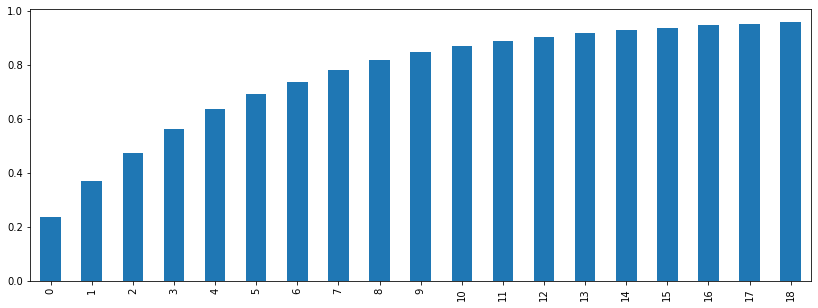

In [402]:
data = []
for i in range(1, len(pca.explained_variance_ratio_)):
    data.append((i, pca.explained_variance_ratio_[:i].sum()))
pd.DataFrame(data)[1].plot(kind="bar")

In [346]:
X_pca = pca.transform(X)

In [404]:
y_bugs = methods_dep_var[methods[1]].post_release_bugs

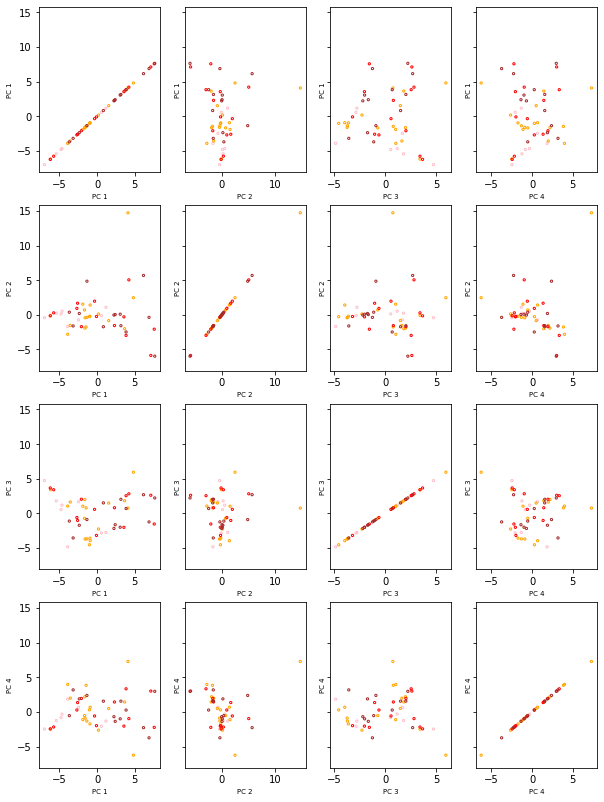

In [409]:
#plt.scatter(X_pca, y)
n_components = 4
fig, axes = plt.subplots(nrows=n_components, ncols=n_components, sharey=True, figsize=(10.0, 14.0))
for i in range(0,n_components):
    for j in range(0,n_components):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ["pink",'orange','red','brown','black']
        ranges = [(0,y_bugs.quantile(0.25)),(y_bugs.quantile(0.25),y_bugs.quantile(0.5))\
                  ,(y_bugs.quantile(0.5),y_bugs.quantile(0.75)), (y_bugs.quantile(0.75),y_bugs.quantile(1))]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y_bugs>=rang[0]) & (y_bugs<rang[1])
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)

In [421]:
df = pd.DataFrame(X)
df.columns = df.columns.astype(str)

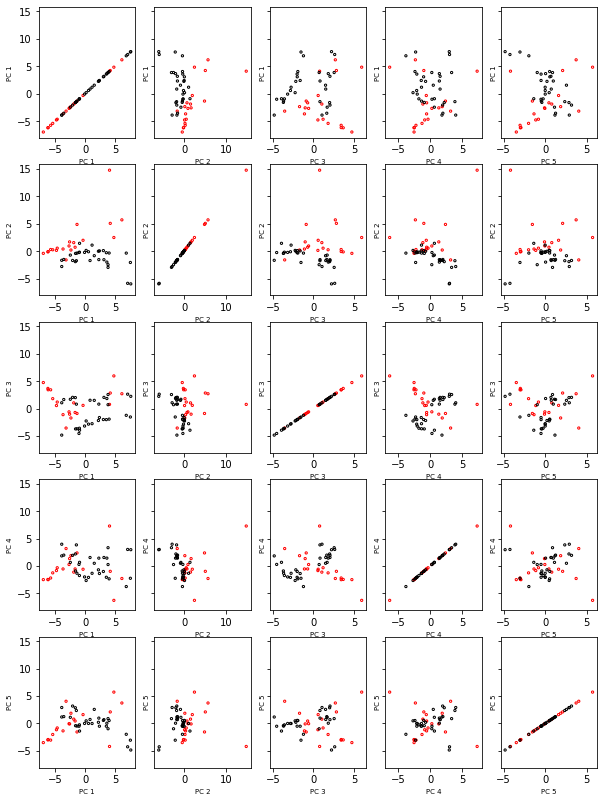

In [381]:
#plt.scatter(X_pca, y)
fig, axes = plt.subplots(nrows=5, ncols=5, sharey=True, figsize=(10.0, 14.0))
for i in range(0,5):
    for j in range(0,5):
        ax = axes[i][j]
        ax.set_xlabel(f"PC {j+1}", fontsize = 7)
        ax.set_ylabel(f"PC {i+1}", fontsize = 7)
        colors = ['r','black']
        ranges = ["gradle", "maven"]
        for rang, color in zip(ranges, colors):
            indicesToKeep = (y==rang)
            ax.scatter(finalDf.loc[indicesToKeep, j],
                       finalDf.loc[indicesToKeep, i],
                       s = 5,
                       facecolors='none',
                       edgecolors=color)